In [ ]:
# Watershed ΔMI mapping (LAG - NO LAG) — wells colored by delta_mi (FIXED VERSION)
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def create_watershed_mi_delta_maps_fixed():
    """
    Create watershed maps for each gage (ΔMI version) with fixed top-10 annotations.
    Colors wells by delta_mi (mi_lag - mi_no_lag).
    Saves to ../reports/figures/mi_delta_top10_fixed
    """
    print("=== Creating Watershed ΔMI Maps (FIXED VERSION with Red Highlights) ===")
    save_dir = "../reports/figures/mi_delta_top10_fixed"
    os.makedirs(save_dir, exist_ok=True)

    # Load geographic datasets
    print("Loading datasets...")
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    stream_gdf   = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf     = gpd.read_file('../data/raw/hydrography/lake.shp')
    gage_df      = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

    # Support tables for joining well geometry
    reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv')
    well_locations  = pd.read_csv('../data/processed/well_reach.csv')[['well_id', 'well_lat', 'well_lon']].drop_duplicates()

    # ΔMI well–gage data
    delta_mi_df = pd.read_csv('../data/processed/mi_compare_lag_vs_no_lag_by_pair.csv')
    delta_mi_df = delta_mi_df[['well_id', 'gage_id', 'delta_mi']].dropna().drop_duplicates()
    delta_mi_df['gage_id'] = delta_mi_df['gage_id'].astype(int)

    print(f"Using ΔMI data for well-gage relationships: {len(delta_mi_df)} unique pairs")

    # Upstream relationships (optional)
    try:
        terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
        print("✅ Loaded terminal relationships")
    except FileNotFoundError:
        print("⚠️ Terminal relationships file not found, using simplified extent")
        terminal_relationships = None

    print("✅ All datasets loaded")

    # Merge data using numeric IDs
    print("Merging data...")
    reach_distances['well_id_numeric'] = pd.to_numeric(reach_distances['Well_ID'], errors='coerce')
    well_locations['well_id_numeric']  = pd.to_numeric(well_locations['well_id'], errors='coerce')
    delta_mi_df['well_id_numeric']     = pd.to_numeric(delta_mi_df['well_id'], errors='coerce')

    merge1 = pd.merge(reach_distances, well_locations, on='well_id_numeric', how='inner')
    print(f"After adding coordinates: {len(merge1)} wells")

    final_data = pd.merge(merge1, delta_mi_df, on='well_id_numeric', how='inner')
    print(f"Final merged data: {len(final_data)} wells with gage relationships")

    if len(final_data) == 0:
        print("❌ No data after merging - cannot create maps")
        return

    # Ensure CRS
    subbasin_gdf = subbasin_gdf.to_crs("EPSG:4326")
    stream_gdf   = stream_gdf.to_crs("EPSG:4326")
    lake_gdf     = lake_gdf.to_crs("EPSG:4326")

    # Unique gages to map
    unique_gages = final_data['gage_id'].dropna().unique()
    print(f"Creating maps for {len(unique_gages)} gages: {unique_gages}")

    for gage_id in tqdm(unique_gages, desc="Creating FIXED ΔMI maps"):
        try:
            gage_wells = final_data[final_data['gage_id'] == gage_id].copy()
            if len(gage_wells) == 0:
                continue
            create_single_styled_map_mi_delta_fixed(
                gage_id, gage_wells, subbasin_gdf, stream_gdf,
                lake_gdf, gage_df, terminal_relationships, save_dir
            )
        except Exception as e:
            print(f"❌ Error for gage {gage_id}: {e}")
            import traceback
            traceback.print_exc()

    print(f"✅ Maps saved to: {save_dir}")

def get_gage_watersheds_styled(gage_id, subbasin_gdf, gage_df, terminal_relationships=None):
    """Get terminal and upstream basins for a gage - styled version (shared)."""
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs), gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    gage_point = Point(gage_lon, gage_lat)
    gage_gdf = gpd.GeoDataFrame([1], geometry=[gage_point], crs="EPSG:4326")
    gage_gdf = gage_gdf.to_crs(subbasin_gdf.crs)
    gage_point = gage_gdf.geometry.iloc[0]

    containing = subbasin_gdf[subbasin_gdf.geometry.contains(gage_point)]
    if len(containing) > 0:
        terminal_basin = containing.iloc[[0]]
    else:
        distances = subbasin_gdf.geometry.distance(gage_point)
        terminal_basin = subbasin_gdf.iloc[[distances.idxmin()]]

    upstream_basins = gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    if terminal_relationships is not None:
        if 'Gage_ID' in terminal_relationships.columns:
            gage_col, upstream_col = 'Gage_ID', 'Upstream_Catchment_ID'
        else:
            gage_col, upstream_col = 'gage_id', 'upstream_catchment_id'

        linkno_col = None
        for col in ['linkno', 'LINKNO', 'LinkNo', 'LINK_NO']:
            if col in subbasin_gdf.columns:
                linkno_col = col
                break

        if linkno_col and gage_col in terminal_relationships.columns:
            upstream_catchments = terminal_relationships.loc[
                terminal_relationships[gage_col] == gage_id, upstream_col
            ].dropna().astype(int).tolist()

            if upstream_catchments:
                upstream_basins = subbasin_gdf[
                    subbasin_gdf[linkno_col].astype(int).isin(upstream_catchments)
                ].copy()

                if not terminal_basin.empty:
                    terminal_linkno = int(terminal_basin.iloc[0][linkno_col])
                    upstream_basins = upstream_basins[
                        upstream_basins[linkno_col].astype(int) != terminal_linkno
                    ]

    return terminal_basin, upstream_basins

def create_single_styled_map_mi_delta_fixed(gage_id, gage_wells, subbasin_gdf, stream_gdf, lake_gdf,
                                           gage_df, terminal_relationships, save_dir,
                                           dmi_abs_max_global=None):
    """
    Create a single ΔMI map with FIXED top-10 annotation and RED highlights.
    Wells colored by delta_mi, and annotate the top-10 wells with red circles and labels.
    """
    # ---- gage info
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"No gage info for {gage_id}")
        return False

    gage_name = gage_info.iloc[0].get('name', f'Gage {gage_id}')
    gage_lat  = gage_info.iloc[0]['latitude']
    gage_lon  = gage_info.iloc[0]['longitude']

    # ---- watersheds
    terminal_basin, upstream_basins = get_gage_watersheds_styled(
        gage_id, subbasin_gdf, gage_df, terminal_relationships
    )
    if terminal_basin.empty:
        print(f"No terminal basin found for gage {gage_id}")
        return False

    # ---- sort for plotting 
    gage_wells = gage_wells.copy()
    gage_wells = gage_wells.sort_values('delta_mi', ascending=False)

    # ---- figure layout
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax_main = plt.subplot2grid((10, 10), (0, 0), colspan=7, rowspan=10)
    ax_main.set_facecolor('white')

    # polygons
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax_main, color='#B8860B', alpha=0.8,
                            edgecolor='#8B7355', linewidth=2, zorder=1)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax_main, color='#F5E6D3', alpha=0.6,
                             edgecolor='#D2B48C', linewidth=1.5, zorder=1)

    # clip base layers
    all_basins = pd.concat([terminal_basin, upstream_basins], ignore_index=True)
    if not all_basins.empty:
        watershed_union = all_basins.unary_union
        local_streams = stream_gdf[stream_gdf.geometry.intersects(watershed_union)]
        local_lakes   = lake_gdf[lake_gdf.geometry.intersects(watershed_union)]
    else:
        from shapely.geometry import box
        all_lons = [gage_lon] + gage_wells['well_lon'].tolist()
        all_lats = [gage_lat] + gage_wells['well_lat'].tolist()
        min_lon, max_lon = min(all_lons), max(all_lons)
        min_lat, max_lat = min(all_lats), max(all_lats)
        buffer = max(max_lon - min_lon, max_lat - min_lat) * 0.3 if (max_lon > min_lon and max_lat > min_lat) else 0.1
        extent_box = box(min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer)
        local_streams = stream_gdf[stream_gdf.geometry.intersects(extent_box)]
        local_lakes   = lake_gdf[lake_gdf.geometry.intersects(extent_box)]

    if not local_streams.empty:
        local_streams.plot(ax=ax_main, color='#4A90E2', linewidth=1.5, alpha=0.8, zorder=2)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax_main, color='#E6F3FF', alpha=0.8, edgecolor='#4A90E2', linewidth=0.8, zorder=2)

    # ---- color normalization
    dmi_vals = gage_wells['delta_mi'].astype(float).replace([np.inf, -np.inf], np.nan)
    if dmi_abs_max_global is not None and np.isfinite(dmi_abs_max_global) and dmi_abs_max_global > 0:
        vlim = float(dmi_abs_max_global)
    else:
        # robust symmetric scaling by local 95% percentile of |ΔMI|
        p = 95
        vmax = np.nanpercentile(np.abs(dmi_vals.dropna()), p) if dmi_vals.notna().any() else 1e-6
        vlim = float(vmax) if np.isfinite(vmax) and vmax > 0 else 1e-6
    norm = plt.Normalize(vmin=-vlim, vmax=vlim)

    # ---- scatter of wells
    scatter = None
    if len(gage_wells) > 0:
        scatter = ax_main.scatter(
            gage_wells['well_lon'], gage_wells['well_lat'],
            c=gage_wells['delta_mi'], cmap='coolwarm', norm=norm,
            s=90, alpha=0.9, edgecolor='black', linewidth=0.8, zorder=4
        )

    # ---- gage star
    ax_main.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=500,
                    edgecolor='black', linewidth=2, zorder=10)

    # ---- extent
    if not all_basins.empty:
        bounds = all_basins.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax_main.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax_main.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    else:
        all_lons = list(gage_wells['well_lon']) + [gage_lon]
        all_lats = list(gage_wells['well_lat']) + [gage_lat]
        lon_buffer = (max(all_lons) - min(all_lons)) * 0.2
        lat_buffer = (max(all_lats) - min(all_lats)) * 0.2
        ax_main.set_xlim(min(all_lons) - lon_buffer, max(all_lons) + lon_buffer)
        ax_main.set_ylim(min(all_lats) - lat_buffer, max(all_lats) + lat_buffer)

    # ---- titles / axes
    ax_main.set_title(f'Wells by ΔMI (Lag − No-lag) - TOP 10 HIGHLIGHTED:\n {gage_name}\nGage ID: {gage_id}',
                      fontsize=14, fontweight='bold', pad=15)
    ax_main.set_xlabel('Longitude', fontsize=11)
    ax_main.set_ylabel('Latitude', fontsize=11)
    for spine in ax_main.spines.values():
        spine.set_visible(False)
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='lightgray')
    ax_main.tick_params(labelsize=9)

    # ---- inset
    ax_inset = plt.subplot2grid((10, 10), (0, 7), colspan=3, rowspan=3)
    ax_inset.set_facecolor('white')
    plot_overview_inset_styled(ax_inset, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id)

    # ---- colorbar
    if scatter is not None:
        cbar_ax = plt.subplot2grid((10, 10), (4, 7), colspan=3, rowspan=1)
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('ΔMI = MI(lag) − MI(no-lag)', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=8)

    # ---- FIXED: annotate top-10 by |ΔMI| with RED highlights and smart positioning
    if len(gage_wells) > 0:
        # Fix column name issue: use well_id_numeric instead of well_id
        required_cols = ['well_id_numeric', 'well_lon', 'well_lat', 'delta_mi']
        if all(col in gage_wells.columns for col in required_cols):
            annot_df = gage_wells[required_cols].dropna(subset=['well_lon','well_lat','delta_mi'])
            if len(annot_df) > 0:
                topN = min(10, len(annot_df))
                top_wells = annot_df.reindex(
                    annot_df['delta_mi'].abs().sort_values(ascending=False).index
                ).head(topN)

                # Get plot boundaries for adaptive positioning
                x0, x1 = ax_main.get_xlim()
                y0, y1 = ax_main.get_ylim()
                dx = (x1 - x0) * 0.08  # Increased offset for better separation
                dy = (y1 - y0) * 0.08

                # RED outline circles for top 10 wells
                ax_main.scatter(
                    top_wells['well_lon'], top_wells['well_lat'],
                    facecolors='none', edgecolors='red', linewidths=2.5,  # Changed to red
                    s=180, zorder=12, alpha=0.9
                )

                # Smart positioning algorithm to avoid overlaps
                placed_positions = [(gage_lon, gage_lat)]  # Avoid gage position
                
                for i, (_, row) in enumerate(top_wells.iterrows()):
                    well_x, well_y = row['well_lon'], row['well_lat']
                    
                    # Try different positions around the well
                    candidate_positions = [
                        (well_x + dx, well_y + dy),    # NE
                        (well_x - dx, well_y + dy),    # NW  
                        (well_x + dx, well_y - dy),    # SE
                        (well_x - dx, well_y - dy),    # SW
                        (well_x + 1.5*dx, well_y),     # E
                        (well_x - 1.5*dx, well_y),     # W
                        (well_x, well_y + 1.5*dy),     # N
                        (well_x, well_y - 1.5*dy),     # S
                        (well_x + 2*dx, well_y + 0.5*dy),  # Far NE
                        (well_x - 2*dx, well_y - 0.5*dy),  # Far SW
                    ]
                    
                    # Find the position with minimum conflicts
                    best_pos = candidate_positions[0]
                    min_conflicts = float('inf')
                    
                    for candidate_x, candidate_y in candidate_positions:
                        # Count conflicts with existing positions
                        conflict_count = 0
                        min_distance = float('inf')
                        
                        for placed_x, placed_y in placed_positions:
                            distance = np.sqrt((candidate_x - placed_x)**2 + (candidate_y - placed_y)**2)
                            min_distance = min(min_distance, distance)
                            if distance < dx * 1.2:  # Too close
                                conflict_count += 1
                        
                        # Check if position is within plot bounds
                        if not (x0 <= candidate_x <= x1 and y0 <= candidate_y <= y1):
                            conflict_count += 10  # Heavy penalty for out of bounds
                            
                        if conflict_count < min_conflicts or (conflict_count == min_conflicts and min_distance > dx * 0.8):
                            min_conflicts = conflict_count
                            best_pos = (candidate_x, candidate_y)
                    
                    placed_positions.append(best_pos)
                    label_x, label_y = best_pos
                    
                    # Create label
                    label = f"#{i+1}: Well {int(row['well_id_numeric'])}\nΔMI={row['delta_mi']:.3f}"
                    
                    # Draw arrow from well to label
                    ax_main.annotate(
                        label,
                        xy=(well_x, well_y),           # anchor point (well location)
                        xytext=(label_x, label_y),     # label position
                        textcoords='data',
                        arrowprops=dict(arrowstyle="->", color='red', lw=1.3),  # Red arrows
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                                edgecolor="red", linewidth=1.2, alpha=0.95),    # Red borders
                        fontsize=8, fontweight='bold', zorder=20,
                        ha='center', va='center'
                    )

    # ---- stats + legend
    add_delta_mi_statistics_and_legend(fig, ax_main, gage_wells, gage_id, terminal_basin, upstream_basins)

    # ---- save
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:40]
    filename = f"gage_{int(gage_id)}_delta_mi_{safe_name}_FIXED.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', pad_inches=0.1)
    plt.close()
    print(f"✅ Saved FIXED map for gage {gage_id}: {filename}")
    return True

def plot_overview_inset_styled(ax, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id):
    """Overview inset (shared)."""
    subbasin_gdf.plot(ax=ax, color='#FAFAFA', edgecolor='#B0B0B0', linewidth=0.6, alpha=0.9)
    lake_gdf.plot(ax=ax, color='#D6EAF8', alpha=0.9, edgecolor='#3498DB', linewidth=0.6)

    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color='#CD853F', alpha=0.8, edgecolor='#8B7355', linewidth=1.5)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax, color='#F5E6D3', alpha=0.7, edgecolor='#D2B48C', linewidth=1.2)

    ax.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=150,
               edgecolor='black', linewidth=1.5, zorder=5)

    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

    ax.set_title('Basin Overview', fontsize=10, fontweight='bold', pad=8)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True); spine.set_linewidth(2); spine.set_edgecolor('black')
    ax.set_aspect('equal')

def add_delta_mi_statistics_and_legend(fig, ax_main, gage_wells, gage_id,
                                       terminal_basin, upstream_basins):
    """Stats box + legend (ΔMI version)."""
    watershed_info = ""
    if not terminal_basin.empty:
        watershed_info += "Terminal Basin: 1\n"
    if not upstream_basins.empty:
        watershed_info += f"Upstream Basins: {len(upstream_basins)}\n"

    wells_n = len(gage_wells) if gage_wells is not None else 0
    if wells_n > 0 and 'delta_mi' in gage_wells.columns:
        dmi = gage_wells['delta_mi'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if len(dmi) > 0:
            min_d  = float(np.nanmin(dmi))
            mean_d = float(np.nanmean(dmi))
            p90_d  = float(np.nanpercentile(dmi, 90))
            max_d  = float(np.nanmax(dmi))
            pos_pct = 100.0 * float(np.mean(dmi > 0))

            stats_text = (
                f"{watershed_info}"
                f"Wells: {wells_n}\n"
                f"Min ΔMI:  {min_d:.3f}\n"
                f"Mean ΔMI: {mean_d:.3f}\n"
                f"P90 ΔMI:  {p90_d:.3f}\n"
                f"Max ΔMI:  {max_d:.3f}\n"
                f"% ΔMI>0:  {pos_pct:.1f}%"
            )
        else:
            stats_text = f"{watershed_info}Wells: {wells_n}\nNo valid ΔMI values"
    else:
        stats_text = f"{watershed_info}Wells: {wells_n}\nNo ΔMI column"

    ax_main.text(
        0.02, 0.98, stats_text, transform=ax_main.transAxes,
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                  alpha=0.95, edgecolor='black', linewidth=1),
        verticalalignment='top', fontsize=10, fontweight='bold', zorder=15
    )

    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w',
                   markerfacecolor='#FFD700', markersize=18,
                   markeredgecolor='black', markeredgewidth=1.5,
                   label=f'Gage {int(gage_id)}', linestyle='None'),
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor='none', markersize=12,
                   markeredgecolor='red', markeredgewidth=2.5,
                   label='Top 10 Wells (by |ΔMI|)', linestyle='None'),
    ]
    if not terminal_basin.empty:
        legend_elements.append(
            plt.Rectangle((0,0), 1,1, facecolor='#B8860B', edgecolor='#8B7355',
                          alpha=0.8, label='Terminal Basin (Gage Location)')
        )
    if not upstream_basins.empty:
        legend_elements.append(
            plt.Rectangle((0,0), 1,1, facecolor='#F5E6D3', edgecolor='#D2B48C',
                          alpha=0.6, label='Upstream Basins')
        )

    ax_main.legend(handles=legend_elements, loc='lower left',
                   bbox_to_anchor=(0.02, 0.02), fontsize=9,
                   frameon=True, fancybox=False, shadow=False,
                   edgecolor='black', facecolor='white', framealpha=0.95)

# Run the FIXED version
create_watershed_mi_delta_maps_fixed()

In [2]:
import pandas as pd
import geopandas as gpd

In [ ]:
# Run the watershed correlation analysis with top 10% correlation data
run_watershed_correlation_analysis()

In [6]:
no_lag = pd.read_csv('../data/features/q_buffer2_pair_delta_30m.csv')
no_lag.head()

,well_id,date,wte,gse,gage_id,well_lat,well_lon,gage_lat,gage_lon,wte_meters,q,bfd,delta_wte,delta_q
0,3.946430e+14,1975-01-01,5954.322586,5955.0,10152000,39.778571,-111.487970,40.150232,-111.726039,1814.877524,96.0,1.0,0.000000,0.0
1,4.005100e+14,1975-01-01,4642.123472,4720.0,10152000,40.086067,-111.595474,40.150232,-111.726039,1414.919234,96.0,1.0,0.000000,0.0
2,4.005270e+14,1975-01-01,4595.247928,4622.0,10152000,40.090788,-111.657423,40.150232,-111.726039,1400.631568,96.0,1.0,0.000000,0.0
3,4.005270e+14,1975-01-01,4603.818829,4640.0,10152000,40.090788,-111.660479,40.150232,-111.726039,1403.243979,96.0,1.0,8.570901,0.0
4,4.005280e+14,1975-01-01,4599.508513,4625.0,10152000,40.091066,-111.657423,40.150232,-111.726039,1401.930195,96.0,1.0,0.000000,0.0


In [3]:
subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')
well_gdf = gpd.read_file('../data/raw/hydrography/well_shp.shp')
stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')

In [4]:
reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv').rename(columns=str.lower)
reach_distances.head()


,well_id,reach_id,reach_elevation,distance_to_reach,downstream_gage
0,3.810331e+14,710579638.0,2018.0,15.997118,NaN
1,3.810371e+14,710579638.0,2018.0,387.946514,NaN
2,3.811521e+14,710579638.0,2018.0,642.085536,NaN
3,3.812361e+14,710258231.0,2033.5,95.717740,NaN
4,3.821131e+14,710549872.0,1770.0,375.764745,NaN


In [5]:
well_gage = pd.read_csv('../data/processed/wells_with_catchment_info.csv')
well_gage.head()

,well_id,well_name,lat_dec,long_dec,gse,geometry,catchment_id,gage_id,gage_name
0,3.946181e+14,(D-12- 4)16ccb- 1,39.771627,-111.488248,5980.0,POINT (-111.4882484 39.7716267),710648999.0,10152000.0,SPANISH FORK NEAR LAKE SHORE - UTAH
1,3.946341e+14,(D-12- 4)16bcc- 1,39.776071,-111.488248,5960.0,POINT (-111.4882483 39.7760711),710647014.0,10152000.0,SPANISH FORK NEAR LAKE SHORE - UTAH
2,3.946431e+14,(D-12- 4)16bcb- 1,39.778571,-111.487970,5955.0,POINT (-111.4879704 39.77857106),710647014.0,10152000.0,SPANISH FORK NEAR LAKE SHORE - UTAH
3,3.946491e+14,(D-12- 4)17abd- 1,39.780238,-111.494915,5938.0,POINT (-111.4949154 39.78023766),710549798.0,10152000.0,SPANISH FORK NEAR LAKE SHORE - UTAH
4,3.947461e+14,(D-12- 4) 9bab- 1,39.796071,-111.482970,5977.0,POINT (-111.4829697 39.79607075),710647014.0,10152000.0,SPANISH FORK NEAR LAKE SHORE - UTAH


# plot the top 10 r squared wells

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import linregress
import warnings

warnings.filterwarnings('ignore')

# Set matplotlib style for clean, minimal maps
plt.style.use('default')
plt.rcParams['font.family'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['font.size'] = 10


def calculate_well_gage_correlations(no_lag_data, min_points=10):
    """
    Calculate R-squared values between each well and its associated gage
    using a no-lag relationship: delta_q(t) vs delta_wte(t).

    This function:
    - Drops NaNs in both variables
    - Skips pairs with constant X or Y (to avoid linregress errors)
    - Returns a DataFrame with one row per well–gage pair
    """
    print("=== Calculating Well-Gage Correlations (ΔQ vs ΔWTE_no_lag) ===")

    # Group by well and gage to calculate R-squared
    correlation_results = []
    grouped = no_lag_data.groupby(['well_id', 'gage_id'])
    print(f"Processing {len(grouped)} well-gage pairs...")

    skipped_low_n = 0
    skipped_constant_x = 0
    skipped_constant_y = 0

    for (well_id, gage_id), group in tqdm(grouped, desc="Calculating correlations"):
        # Remove NaN values in the variables used
        clean_data = group.dropna(subset=['delta_wte', 'delta_q'])

        # Enforce minimum observations
        if len(clean_data) < min_points:
            skipped_low_n += 1
            continue

        # Require variability in X and Y
        if clean_data['delta_wte'].nunique() <= 1:
            skipped_constant_x += 1
            continue
        if clean_data['delta_q'].nunique() <= 1:
            skipped_constant_y += 1
            continue

        try:
            # Linear regression of ΔQ(t) on ΔWTE(t) - NO LAG
            slope, intercept, r_value, p_value, std_err = linregress(
                clean_data['delta_wte'],
                clean_data['delta_q']
            )
            r_squared = r_value ** 2

            # Extract coordinates (assumed constant within the group)
            well_lat = clean_data['well_lat'].iloc[0]
            well_lon = clean_data['well_lon'].iloc[0]
            gage_lat = clean_data['gage_lat'].iloc[0]
            gage_lon = clean_data['gage_lon'].iloc[0]

            correlation_results.append({
                'well_id': well_id,
                'gage_id': gage_id,
                'r_squared': r_squared,
                'r_value': r_value,
                'p_value': p_value,
                'n_observations': len(clean_data),
                'well_lat': well_lat,
                'well_lon': well_lon,
                'gage_lat': gage_lat,
                'gage_lon': gage_lon
            })
        except Exception as e:
            # Defensive: this should be very rare after checks above
            print(f"Error calculating correlation for well {well_id}, gage {gage_id}: {e}")

    correlation_df = pd.DataFrame(correlation_results)
    print(f"Successfully calculated correlations for {len(correlation_df)} well-gage pairs")
    print(f"Skipped (n<{min_points}): {skipped_low_n} | constant X: {skipped_constant_x} | constant Y: {skipped_constant_y}")

    return correlation_df


def load_watershed_data():
    """Load watershed relationship data (terminal gage → upstream catchments)."""
    try:
        df = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')

        # Standardize column names
        rename_map = {}
        if 'Gage_ID' in df.columns:
            rename_map['Gage_ID'] = 'gage_id'
        if 'Upstream_Catchment_ID' in df.columns:
            rename_map['Upstream_Catchment_ID'] = 'upstream_catchment_id'
        if rename_map:
            df = df.rename(columns=rename_map)

        # Enforce types where possible
        if 'gage_id' in df.columns:
            df['gage_id'] = pd.to_numeric(df['gage_id'], errors='coerce').astype('Int64')
        if 'upstream_catchment_id' in df.columns:
            df['upstream_catchment_id'] = pd.to_numeric(df['upstream_catchment_id'], errors='coerce').astype('Int64')

        return df
    except Exception as e:
        print(f"Warning: Could not load watershed relationships: {e}")
        return None


def _ensure_point_in_subbasin_crs(lon, lat, subbasin_gdf):
    """
    Build a GeoSeries point at (lon, lat) and convert to the subbasin CRS if needed.
    """
    from shapely.geometry import Point
    gpt = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326")
    try:
        if subbasin_gdf.crs is not None and subbasin_gdf.crs != "EPSG:4326":
            gpt = gpt.to_crs(subbasin_gdf.crs)
    except Exception as e:
        print(f"CRS transform failed; proceeding in EPSG:4326. Error: {e}")
    return gpt


def get_gage_terminal_basin(gage_id, subbasin_gdf, gage_df):
    """
    Get the terminal basin (catchment polygon) that contains the gage.
    If containment fails (e.g., due to topology or slight offsets), use nearest.
    Handles CRS properly.
    """
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"Warning: No gage info found for gage {gage_id}")
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']
    print(f"Debug: Looking for terminal basin for gage {gage_id} at ({gage_lon}, {gage_lat})")

    gpt = _ensure_point_in_subbasin_crs(gage_lon, gage_lat, subbasin_gdf)

    # Containment test
    try:
        containing = subbasin_gdf[subbasin_gdf.geometry.contains(gpt.iloc[0])]
        if len(containing) > 0:
            idx = containing.index[0]
            print(f"Debug: Found containing basin {idx} for gage {gage_id}")
            return subbasin_gdf.loc[[idx]]
    except Exception as e:
        print(f"Debug: Containment check failed for gage {gage_id}: {e}")

    # Fallback: nearest polygon (distance computed in subbasin CRS)
    print(f"Debug: No containing basin found, finding nearest for gage {gage_id}")
    try:
        distances = subbasin_gdf.geometry.distance(gpt.iloc[0])
        nearest_idx = distances.idxmin()
        nearest_dist = distances.min()
        print(f"Debug: Nearest basin {nearest_idx} at distance {nearest_dist} for gage {gage_id}")
        return subbasin_gdf.loc[[nearest_idx]]
    except Exception as e:
        print(f"Warning: Nearest basin selection failed for gage {gage_id}: {e}")
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)


def get_gage_watersheds(gage_id, subbasin_gdf, gage_df, terminal_relationships=None):
    """
    Get the terminal basin and all upstream basins for a gage.
    - If relationships are provided, select upstream catchments by linkno/LINKNO.
    - The terminal basin is excluded from the upstream set.
    """
    terminal_basin = get_gage_terminal_basin(gage_id, subbasin_gdf, gage_df)
    print(f"Debug: Gage {gage_id} - Terminal basin found: {not terminal_basin.empty}")

    upstream_basins = gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    if terminal_relationships is not None and 'gage_id' in terminal_relationships.columns:
        # Identify the linkno column
        linkno_col = None
        for cand in ['linkno', 'LINKNO', 'LinkNo', 'LINK_NO']:
            if cand in subbasin_gdf.columns:
                linkno_col = cand
                break

        if linkno_col is None:
            print("Warning: No linkno-like column found in subbasin_gdf; upstream basins cannot be resolved.")
            return terminal_basin, upstream_basins

        # Get upstream catchments list for this gage
        upstream_catchments = terminal_relationships.loc[
            terminal_relationships['gage_id'] == gage_id, 'upstream_catchment_id'
        ].dropna().astype(int).tolist()

        print(f"Debug: Gage {gage_id} - Upstream catchments: {len(upstream_catchments)}")

        if upstream_catchments:
            upstream_basins = subbasin_gdf[subbasin_gdf[linkno_col].astype(int).isin(upstream_catchments)].copy()
            # Remove terminal basin if included
            if not terminal_basin.empty:
                terminal_linkno = int(terminal_basin.iloc[0][linkno_col])
                upstream_basins = upstream_basins[upstream_basins[linkno_col].astype(int) != terminal_linkno]

    return terminal_basin, upstream_basins


def create_clean_correlation_maps_with_watersheds(
    correlation_df,
    no_lag_data,
    save_dir='../reports/figures/gage_well_correlations_watershed_no_lag'
):
    """
    Create clean correlation maps with watershed boundaries and overview inset.

    Key changes:
    - Iterate over gages found in the *input no_lag_data*, not only those that survived correlation,
      so gages with 0 valid wells still get a QA map (terminal basin + star).
    - Defensive plotting when no wells exist.
    """
    print("=== Creating Clean Correlation Maps with Watersheds (NO LAG) ===")
    os.makedirs(save_dir, exist_ok=True)

    # Load geographic data
    try:
        subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
        stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
        lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')
        gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

        # Load watershed relationships
        terminal_relationships = load_watershed_data()

        print("✅ Geographic data loaded successfully")
        print(f"Subbasin columns: {list(subbasin_gdf.columns)}")
        print(f"Subbasin CRS: {subbasin_gdf.crs}")
        print(f"Total catchments: {len(subbasin_gdf)}")
    except Exception as e:
        print(f"❌ Error loading geographic data: {e}")
        return

    # Use all gages from the input no_lag dataset to ensure coverage
    unique_gages = pd.Series(no_lag_data['gage_id'].dropna().unique()).astype(int).tolist()
    print(f"Creating watershed maps for {len(unique_gages)} gages...")

    for gage_id in tqdm(unique_gages, desc="Creating watershed correlation maps"):
        try:
            result = create_single_watershed_map(
                gage_id,
                correlation_df,
                subbasin_gdf,
                stream_gdf,
                lake_gdf,
                gage_df,
                terminal_relationships,
                save_dir
            )
            if result is False:
                print(f"⚠️ Skipped map creation for Gage {gage_id}")
        except Exception as e:
            print(f"❌ Failed to create map for Gage {gage_id}: {e}")
            import traceback
            traceback.print_exc()

    print(f"✅ All watershed correlation maps saved to: {save_dir}")


def add_labels_with_leader_lines(ax, wells_data, gage_lon, gage_lat, max_distance=0.05):
    """
    Add R² labels with leader lines to avoid overlaps.
    If wells_data is empty, this function does nothing.
    """
    if wells_data is None or wells_data.empty:
        return

    positions = []
    for i, (_, well) in enumerate(wells_data.iterrows()):
        number = i + 1
        well_x, well_y = well['well_lon'], well['well_lat']

        # Try different angles around the well to find non-overlapping position
        angles = [45, 135, 315, 225, 90, 270, 0, 180]
        best_pos = None
        min_conflict = float('inf')

        for angle in angles:
            angle_rad = np.radians(angle)
            label_x = well_x + max_distance * np.cos(angle_rad)
            label_y = well_y + max_distance * np.sin(angle_rad)

            conflict_count = 0
            gage_dist = np.sqrt((label_x - gage_lon)**2 + (label_y - gage_lat)**2)
            if gage_dist < max_distance * 0.6:
                conflict_count += 2

            for other_pos in positions:
                other_dist = np.sqrt((label_x - other_pos[0])**2 + (label_y - other_pos[1])**2)
                if other_dist < max_distance * 0.7:
                    conflict_count += 1

            if conflict_count < min_conflict:
                min_conflict = conflict_count
                best_pos = (label_x, label_y, angle)

        if best_pos:
            label_x, label_y, angle = best_pos
            positions.append((label_x, label_y))

            ax.plot([well_x, label_x], [well_y, label_y],
                    color='black', linewidth=1.2, alpha=0.7, zorder=11)

            ha = 'left' if angle < 180 else 'right'
            va = 'bottom' if 45 <= angle <= 135 else 'top'
            ax.text(label_x, label_y,
                    f'{number}: R² = {well["r_squared"]:.3f}',
                    ha=ha, va=va,
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                              alpha=0.95, edgecolor='black', linewidth=1),
                    zorder=12)
        else:
            # Fallback to simple offset
            offset_x = 0.025 if i % 2 == 0 else -0.025
            offset_y = 0.020 if i < 3 else -0.010
            ax.text(well_x + offset_x, well_y + offset_y,
                    f'{number}: R² = {well["r_squared"]:.3f}',
                    ha='left' if offset_x > 0 else 'right',
                    va='bottom' if offset_y > 0 else 'top',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                              alpha=0.95, edgecolor='black', linewidth=1),
                    zorder=12)


def create_single_watershed_map(
    gage_id,
    correlation_df,
    subbasin_gdf,
    stream_gdf,
    lake_gdf,
    gage_df,
    terminal_relationships,
    save_dir
):
    """
    Create a single clean correlation map with watershed boundaries and inset map.

    Defensive behaviors:
    - If gage has 0 valid wells, still plot the terminal basin + gage star, and a stats box (Wells: 0).
    - If R² is constant (or a single value), avoid normalizer/colorbar errors.
    """
    print(f"\n=== Processing Gage {gage_id} ===")

    # Well correlations available for this gage
    gage_wells = correlation_df[correlation_df['gage_id'] == gage_id].copy()

    # Gage metadata
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"No gage info found for gage {gage_id}")
        return False

    gage_name = gage_info.iloc[0].get('name', f'Gage {gage_id}')
    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    # Watersheds: terminal + upstream
    terminal_basin, upstream_basins = get_gage_watersheds(
        gage_id, subbasin_gdf, gage_df, terminal_relationships
    )

    # Sort wells by R-squared and get top 10
    if not gage_wells.empty:
        gage_wells = gage_wells.sort_values('r_squared', ascending=False)
        top_10_wells = gage_wells.head(10)
    else:
        top_10_wells = gage_wells  # empty

    # Figure layout
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax_main = plt.subplot2grid((10, 10), (0, 0), colspan=7, rowspan=10)
    ax_main.set_facecolor('white')

    # Plot watershed polygons
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax_main, color='#B8860B', alpha=0.8,
                            edgecolor='#8B7355', linewidth=2, zorder=1)
        print(f"✅ Plotted terminal basin for gage {gage_id}")
    else:
        print(f"⚠️ No terminal basin found for gage {gage_id}")

    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax_main, color='#F5E6D3', alpha=0.6,
                             edgecolor='#D2B48C', linewidth=1.5, zorder=1)
        print(f"✅ Plotted {len(upstream_basins)} upstream basins for gage {gage_id}")

    # Clip streams/lakes by watershed extent if possible
    all_basins = pd.concat([terminal_basin, upstream_basins], ignore_index=True)
    if not all_basins.empty:
        watershed_union = all_basins.unary_union
        local_streams = stream_gdf[stream_gdf.geometry.intersects(watershed_union)]
        local_lakes = lake_gdf[lake_gdf.geometry.intersects(watershed_union)]
    else:
        # Fallback: extent around the gage and any wells (if exist)
        all_lons = [gage_lon] + (gage_wells['well_lon'].tolist() if not gage_wells.empty else [])
        all_lats = [gage_lat] + (gage_wells['well_lat'].tolist() if not gage_wells.empty else [])
        min_lon, max_lon = min(all_lons), max(all_lons)
        min_lat, max_lat = min(all_lats), max(all_lats)
        buffer = max(max_lon - min_lon, max_lat - min_lat) * 0.3 if (max_lon > min_lon and max_lat > min_lat) else 0.1

        from shapely.geometry import box
        extent_box = box(min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer)
        local_streams = stream_gdf[stream_gdf.geometry.intersects(extent_box)]
        local_lakes = lake_gdf[lake_gdf.geometry.intersects(extent_box)]
        print(f"Using extent-based clipping for gage {gage_id}")

    # Base layers
    if not local_streams.empty:
        local_streams.plot(ax=ax_main, color='#4A90E2', linewidth=1.5, alpha=0.8, zorder=2)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax_main, color='#E6F3FF', alpha=0.8, edgecolor='#4A90E2', linewidth=0.8, zorder=2)

    # Plot ALL wells as small gray circles first
    ax_main.scatter(
        gage_wells['well_lon'],
        gage_wells['well_lat'],
        c='lightgray',
        s=50,
        alpha=0.6,
        edgecolor='gray',
        linewidth=0.5,
        zorder=3
    )

    # Plot wells colored by R-squared using viridis colormap (yellow-green-blue)
    norm = plt.Normalize(vmin=gage_wells['r_squared'].min(), vmax=gage_wells['r_squared'].max())
    scatter = ax_main.scatter(
        gage_wells['well_lon'],
        gage_wells['well_lat'],
        c=gage_wells['r_squared'],
        cmap='viridis',  # Yellow-green-blue colormap
        s=90,
        alpha=0.9,
        edgecolor='black',
        linewidth=0.8,
        zorder=4,
        norm=norm
    )

    # Plot gage as large bright yellow star - NO LABELS
    ax_main.scatter(gage_lon, gage_lat,
              color='#FFD700',  # Bright yellow/gold
              marker='*',       # Star
              s=500,           # Much larger size
              edgecolor='black',  # Black edge
              linewidth=2,
              zorder=10)

    # Add numbers for top 10 wells
    for i, (_, well) in enumerate(top_10_wells.iterrows()):
        number = i + 1

        # Larger red marker for top 10 wells
        ax_main.scatter(well['well_lon'], well['well_lat'],
                  color='red',
                  s=180,
                  marker='o',
                  edgecolor='white',
                  linewidth=2,
                  zorder=8,
                  alpha=0.95)

        # Add number inside the marker
        ax_main.text(well['well_lon'], well['well_lat'],
               str(number),
               ha='center', va='center',
               fontsize=11, fontweight='bold',
               color='white',
               zorder=9)

    # Add R-squared labels with leader lines
    add_labels_with_leader_lines(ax_main, top_10_wells, gage_lon, gage_lat)

    # Set main map extent
    if not all_basins.empty:
        bounds = all_basins.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax_main.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax_main.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    else:
        # Fallback to well and gage extent
        all_lons = list(gage_wells['well_lon']) + [gage_lon]
        all_lats = list(gage_wells['well_lat']) + [gage_lat]
        lon_buffer = (max(all_lons) - min(all_lons)) * 0.2
        lat_buffer = (max(all_lats) - min(all_lats)) * 0.2
        ax_main.set_xlim(min(all_lons) - lon_buffer, max(all_lons) + lon_buffer)
        ax_main.set_ylim(min(all_lats) - lat_buffer, max(all_lats) + lat_buffer)

    # Style main map
    ax_main.set_title(f'Well–Gage Correlations (No Lag): {gage_name}\nGage ID: {gage_id}',
                      fontsize=14, fontweight='bold', pad=15)
    ax_main.set_xlabel('Longitude', fontsize=11)
    ax_main.set_ylabel('Latitude', fontsize=11)
    for spine in ax_main.spines.values():
        spine.set_visible(False)
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='lightgray')
    ax_main.tick_params(labelsize=9)

    # Inset
    ax_inset = plt.subplot2grid((10, 10), (0, 7), colspan=3, rowspan=3)
    ax_inset.set_facecolor('white')
    plot_overview_inset(ax_inset, subbasin_gdf, stream_gdf, lake_gdf,
                        terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id)

    # Colorbar only if we actually plotted colored wells
    if scatter is not None:
        cbar_ax = plt.subplot2grid((10, 10), (4, 7), colspan=3, rowspan=1)
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('R² (Correlation Strength)', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=8)

    # Stats + legend
    add_statistics_and_legend(fig, ax_main, gage_wells, gage_id, terminal_basin, upstream_basins)

    # Save
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:40]
    filename = f"gage_{gage_id}_watershed_no_lag_{safe_name}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none', pad_inches=0.1)
    plt.close()

    print(f"✅ Saved map for gage {gage_id}: {filename}")
    return True


def plot_overview_inset(ax, subbasin_gdf, stream_gdf, lake_gdf,
                        terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id):
    """
    Plot the basin-wide overview inset with highlighted terminal/upstream basins.
    """
    # All catchments
    subbasin_gdf.plot(ax=ax, color='#FAFAFA', edgecolor='#B0B0B0',
                      linewidth=0.6, alpha=0.9)

    # Lakes for context
    lake_gdf.plot(ax=ax, color='#D6EAF8', alpha=0.9,
                  edgecolor='#3498DB', linewidth=0.6)

    # Highlight watersheds
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color='#CD853F', alpha=0.8,
                            edgecolor='#8B7355', linewidth=1.5)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax, color='#F5E6D3', alpha=0.7,
                             edgecolor='#D2B48C', linewidth=1.2)

    # Gage star (small)
    ax.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=150,
               edgecolor='black', linewidth=1.5, zorder=5)

    # Full basin extent
    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

    # Style
    ax.set_title('Basin Overview', fontsize=10, fontweight='bold', pad=8)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')
    ax.set_aspect('equal')


def add_statistics_and_legend(fig, ax_main, gage_wells, gage_id, terminal_basin, upstream_basins):
    """
    Add statistics box and legend to the figure.
    Works whether or not wells exist for the gage.
    """
    # Stats text
    watershed_info = ""
    if not terminal_basin.empty:
        watershed_info += f"Terminal Basin: 1\n"
    if not upstream_basins.empty:
        watershed_info += f"Upstream Basins: {len(upstream_basins)}\n"

    if not gage_wells.empty:
        max_r2 = gage_wells['r_squared'].max()
        mean_r2 = gage_wells['r_squared'].mean()
        wells_n = len(gage_wells)
    else:
        max_r2 = float('nan')
        mean_r2 = float('nan')
        wells_n = 0

    stats_text = (f"{watershed_info}"
                  f"Wells: {wells_n}\n"
                  f"Max R²: {max_r2:.3f}" if wells_n > 0 else f"{watershed_info}Wells: 0")

    if wells_n > 0:
        stats_text += f"\nMean R²: {mean_r2:.3f}"

    ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes,
                 bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                           alpha=0.95, edgecolor='black', linewidth=1),
                 verticalalignment='top', fontsize=10,
                 fontweight='bold', zorder=15)

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w',
                   markerfacecolor='#FFD700', markersize=18,
                   markeredgecolor='black', markeredgewidth=1.5,
                   label=f'Gage {gage_id}', linestyle='None'),
    ]

    if wells_n > 0:
        legend_elements.extend([
            plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor='red', markersize=10,
                       markeredgecolor='white', markeredgewidth=1,
                       label='Top 10 Wells (numbered)', linestyle='None'),
            plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor='lightgray', markersize=8,
                       markeredgecolor='gray', markeredgewidth=0.5,
                       label='Other Wells', linestyle='None')
        ])

    if not terminal_basin.empty:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor='#B8860B', edgecolor='#8B7355',
                          alpha=0.8, label='Terminal Basin (Gage Location)')
        )
    if not upstream_basins.empty:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor='#F5E6D3', edgecolor='#D2B48C',
                          alpha=0.6, label='Upstream Basins')
        )

    ax_main.legend(handles=legend_elements, loc='lower left',
                   bbox_to_anchor=(0.02, 0.02), fontsize=9,
                   frameon=True, fancybox=False, shadow=False,
                   edgecolor='black', facecolor='white', framealpha=0.95)


def create_summary_statistics(correlation_df):
    """
    Create summary statistics and save CSVs.
    """
    print("=== Creating Summary Statistics ===")
    correlation_df.to_csv('../data/processed/well_gage_correlations_no_lag.csv', index=False)

    if not correlation_df.empty:
        gage_summary = correlation_df.groupby('gage_id').agg({
            'r_squared': ['count', 'mean', 'std', 'max', 'min'],
            'n_observations': ['mean', 'sum']
        }).round(4)
        gage_summary.columns = ['_'.join(col) for col in gage_summary.columns]
        gage_summary.to_csv('../data/processed/gage_correlation_summary_no_lag.csv')

        print("✅ Summary statistics saved")
        print(f"Overall correlation statistics:")
        print(f"  Mean R²: {correlation_df['r_squared'].mean():.4f}")
        print(f"  Median R²: {correlation_df['r_squared'].median():.4f}")
        print(f"  Max R²: {correlation_df['r_squared'].max():.4f}")
        print(f"  Wells with R² > 0.1: {(correlation_df['r_squared'] > 0.1).sum()}")
        print(f"  Wells with R² > 0.5: {(correlation_df['r_squared'] > 0.5).sum()}")
    else:
        print("⚠️ correlation_df is empty; no summary CSVs created.")


def run_watershed_correlation_analysis():
    """
    Run the complete watershed correlation analysis using TOP 10% correlation data.

    Steps:
    1) Load top 10% correlation subset (pre-computed)
    2) Load the original no-lag data for geographic context
    3) Render per-gage maps for ALL gages in the subset
    4) Save summary statistics
    """
    print("🚀 Starting Watershed Correlation Analysis (TOP 10% CORRELATION DATA)")

    # Load the top 10% correlation subset created in 05_delta_metrics.ipynb
    try:
        top10_data = pd.read_csv('../data/features/no_lag_top10_correlation_by_gage.csv')
        print(f"✅ Loaded top 10% correlation data with {len(top10_data):,} records")
    except Exception as e:
        print(f"❌ Error loading top 10% correlation data: {e}")
        return

    # Calculate correlations using the top 10% subset
    correlation_df = calculate_well_gage_correlations(top10_data, min_points=10)
    if correlation_df is None:
        print("❌ No correlations calculated (None). Check your data.")
        return

    # Create watershed maps using the top 10% data
    create_clean_correlation_maps_with_watersheds(
        correlation_df, 
        top10_data,
        save_dir='../reports/figures/gage_well_correlations_watershed_top10_no_lag'
    )

    # Create summary stats
    create_summary_statistics(correlation_df)

    print("🎉 Watershed Correlation Analysis (TOP 10%) Complete!")


if __name__ == "__main__":
    try:
        run_watershed_correlation_analysis()
        print("🎉 Watershed analysis completed successfully!")
    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        import traceback
        traceback.print_exc()

🚀 Starting Watershed Correlation Analysis (TOP 10% CORRELATION DATA)
✅ Loaded top 10% correlation data with 9,288 records
=== Calculating Well-Gage Correlations (ΔQ vs ΔWTE_no_lag) ===
Processing 11 well-gage pairs...


Calculating correlations: 100%|██████████| 11/11 [00:00<00:00, 1408.09it/s]

Successfully calculated correlations for 11 well-gage pairs
Skipped (n<10): 0 | constant X: 0 | constant Y: 0
=== Creating Clean Correlation Maps with Watersheds (NO LAG) ===


✅ Geographic data loaded successfully
Subbasin columns: ['ogc_fid', 'linkno', 'geometry']
Subbasin CRS: EPSG:4326
Total catchments: 7013
Creating watershed maps for 4 gages...


Creating watershed correlation maps:   0%|          | 0/4 [00:00<?, ?it/s]findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont


=== Processing Gage 10152000 ===
Debug: Looking for terminal basin for gage 10152000 at (-111.726039, 40.150232)
Debug: Found containing basin 6851 for gage 10152000
Debug: Gage 10152000 - Terminal basin found: True
Debug: Gage 10152000 - Upstream catchments: 110
✅ Plotted terminal basin for gage 10152000
✅ Plotted 109 upstream basins for gage 10152000


findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberati

✅ Saved map for gage 10152000: gage_10152000_watershed_no_lag_SPANISH FORK NEAR LAKE SHORE - UTAH.png

=== Processing Gage 10168000 ===
Debug: Looking for terminal basin for gage 10168000 at (-111.90188, 40.663836)
Debug: Found containing basin 6256 for gage 10168000
Debug: Gage 10168000 - Terminal basin found: True
Debug: Gage 10168000 - Upstream catchments: 6
✅ Plotted terminal basin for gage 10168000
✅ Plotted 5 upstream basins for gage 10168000


findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberati

✅ Saved map for gage 10168000: gage_10168000_watershed_no_lag_LITTLE COTTONWOOD CREEK @ JORDAN RIVER N.png

=== Processing Gage 10163000 ===
Debug: Looking for terminal basin for gage 10163000 at (-111.69937, 40.237732)
Debug: Found containing basin 6959 for gage 10163000
Debug: Gage 10163000 - Terminal basin found: True
Debug: Gage 10163000 - Upstream catchments: 124
✅ Plotted terminal basin for gage 10163000
✅ Plotted 123 upstream basins for gage 10163000


findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberati

✅ Saved map for gage 10163000: gage_10163000_watershed_no_lag_PROVO RIVER AT PROVO - UT.png

=== Processing Gage 10141000 ===
Debug: Looking for terminal basin for gage 10141000 at (-112.091887, 41.278277)
Debug: Found containing basin 6179 for gage 10141000
Debug: Gage 10141000 - Terminal basin found: True
Debug: Gage 10141000 - Upstream catchments: 359
✅ Plotted terminal basin for gage 10141000


findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberati

✅ Plotted 358 upstream basins for gage 10141000


findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberati

✅ Saved map for gage 10141000: gage_10141000_watershed_no_lag_WEBER RIVER NEAR PLAIN CITY - UT.png
✅ All watershed correlation maps saved to: ../reports/figures/gage_well_correlations_watershed_top10_no_lag
=== Creating Summary Statistics ===
✅ Summary statistics saved
Overall correlation statistics:
  Mean R²: 0.3155
  Median R²: 0.3258
  Max R²: 0.5520
  Wells with R² > 0.1: 11
  Wells with R² > 0.5: 2
🎉 Watershed Correlation Analysis (TOP 10%) Complete!
🎉 Watershed analysis completed successfully!


# plot horizontal distance

In [36]:
# Fixed watershed distance mapping code with proper styling (using well_gage data)
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def create_watershed_distance_maps_styled():
    """
    Create watershed maps for each gage using the same style as correlation maps.
    Uses well_gage data for well-gage relationships.
    """
    print("=== Creating Watershed Distance Maps (Styled Version) ===")
    save_dir = "../reports/figures/watershed_distance_maps_styled"
    os.makedirs(save_dir, exist_ok=True)

    # Load all datasets
    print("Loading datasets...")

    # Geographic data
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')
    gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

    # Well data
    reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv')
    well_locations = pd.read_csv('../data/processed/well_reach.csv')[['well_id', 'well_lat', 'well_lon']].drop_duplicates()

    # CHANGED: Use well_gage data for well-gage relationships
    well_gage_data = pd.read_csv('../data/processed/wells_with_catchment_info.csv')
    well_gage_pairs = well_gage_data[['well_id', 'gage_id']].dropna().drop_duplicates()
    print(f"Using well_gage data for well-gage relationships: {len(well_gage_pairs)} unique pairs")

    # Load watershed relationships
    try:
        terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
        print("✅ Loaded terminal relationships")
    except FileNotFoundError:
        print("⚠️ Terminal relationships file not found, using simplified approach")
        terminal_relationships = None

    print("✅ All datasets loaded")

    # Merge data using numeric IDs
    print("Merging data using numeric approach...")

    # Convert to numeric
    reach_distances['well_id_numeric'] = pd.to_numeric(reach_distances['Well_ID'], errors='coerce')
    well_locations['well_id_numeric'] = pd.to_numeric(well_locations['well_id'], errors='coerce')
    well_gage_pairs['well_id_numeric'] = pd.to_numeric(well_gage_pairs['well_id'], errors='coerce')

    # Merge step by step
    merge1 = pd.merge(reach_distances, well_locations, on='well_id_numeric', how='inner')
    print(f"After adding coordinates: {len(merge1)} wells")

    final_data = pd.merge(merge1, well_gage_pairs, on='well_id_numeric', how='inner')
    print(f"Final merged data: {len(final_data)} wells with gage relationships")

    if len(final_data) == 0:
        print("❌ No data after merging - cannot create maps")
        return

    # Ensure CRS consistency
    subbasin_gdf = subbasin_gdf.to_crs("EPSG:4326")
    stream_gdf = stream_gdf.to_crs("EPSG:4326")
    lake_gdf = lake_gdf.to_crs("EPSG:4326")

    # Get unique gages (process all gages)
    unique_gages = final_data['gage_id'].dropna().unique()
    print(f"Creating maps for {len(unique_gages)} gages: {unique_gages}")

    # Create maps
    for gage_id in tqdm(unique_gages, desc="Creating styled maps"):
        try:
            gage_wells = final_data[final_data['gage_id'] == gage_id].copy()
            print(f"\nProcessing Gage {gage_id} with {len(gage_wells)} wells")

            if len(gage_wells) == 0:
                continue

            # Create the map
            create_single_styled_map(gage_id, gage_wells, subbasin_gdf, stream_gdf,
                                   lake_gdf, gage_df, terminal_relationships, save_dir)

        except Exception as e:
            print(f"❌ Error for gage {gage_id}: {e}")
            import traceback
            traceback.print_exc()

    print(f"✅ Maps saved to: {save_dir}")

def get_gage_watersheds_styled(gage_id, subbasin_gdf, gage_df, terminal_relationships=None):
    """Get terminal and upstream basins for a gage - styled version."""
    # Get gage info
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs), gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    # Create gage point
    gage_point = Point(gage_lon, gage_lat)
    gage_gdf = gpd.GeoDataFrame([1], geometry=[gage_point], crs="EPSG:4326")
    gage_gdf = gage_gdf.to_crs(subbasin_gdf.crs)
    gage_point = gage_gdf.geometry.iloc[0]

    # Find terminal basin (containing the gage)
    containing = subbasin_gdf[subbasin_gdf.geometry.contains(gage_point)]
    if len(containing) > 0:
        terminal_basin = containing.iloc[[0]]
    else:
        # Fallback: find nearest basin
        distances = subbasin_gdf.geometry.distance(gage_point)
        nearest_idx = distances.idxmin()
        terminal_basin = subbasin_gdf.iloc[[nearest_idx]]

    # Get upstream basins if relationships are available
    upstream_basins = gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    if terminal_relationships is not None:
        # Standardize column names
        if 'Gage_ID' in terminal_relationships.columns:
            gage_col = 'Gage_ID'
            upstream_col = 'Upstream_Catchment_ID'
        else:
            gage_col = 'gage_id'
            upstream_col = 'upstream_catchment_id'

        # Find linkno column in subbasin_gdf
        linkno_col = None
        for col in ['linkno', 'LINKNO', 'LinkNo', 'LINK_NO']:
            if col in subbasin_gdf.columns:
                linkno_col = col
                break

        if linkno_col and gage_col in terminal_relationships.columns:
            # Get upstream catchments for this gage
            upstream_catchments = terminal_relationships.loc[
                terminal_relationships[gage_col] == gage_id, upstream_col
            ].dropna().astype(int).tolist()

            if upstream_catchments:
                upstream_basins = subbasin_gdf[
                    subbasin_gdf[linkno_col].astype(int).isin(upstream_catchments)
                ].copy()

                # Remove terminal basin if it's included in upstream list
                if not terminal_basin.empty:
                    terminal_linkno = int(terminal_basin.iloc[0][linkno_col])
                    upstream_basins = upstream_basins[
                        upstream_basins[linkno_col].astype(int) != terminal_linkno
                    ]

    return terminal_basin, upstream_basins

def plot_overview_inset_styled(ax, subbasin_gdf, stream_gdf, lake_gdf,
                              terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id):
    """Plot the basin-wide overview inset - styled version."""
    # All catchments
    subbasin_gdf.plot(ax=ax, color='#FAFAFA', edgecolor='#B0B0B0',
                      linewidth=0.6, alpha=0.9)

    # Lakes for context
    lake_gdf.plot(ax=ax, color='#D6EAF8', alpha=0.9,
                  edgecolor='#3498DB', linewidth=0.6)

    # Highlight watersheds
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color='#CD853F', alpha=0.8,
                            edgecolor='#8B7355', linewidth=1.5)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax, color='#F5E6D3', alpha=0.7,
                             edgecolor='#D2B48C', linewidth=1.2)

    # Gage star (small)
    ax.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=150,
               edgecolor='black', linewidth=1.5, zorder=5)

    # Full basin extent
    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

    # Style
    ax.set_title('Basin Overview', fontsize=10, fontweight='bold', pad=8)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')
    ax.set_aspect('equal')

def create_single_styled_map(gage_id, gage_wells, subbasin_gdf, stream_gdf, lake_gdf,
                           gage_df, terminal_relationships, save_dir):
    """Create a single map using the correlation map style."""

    # Get gage info
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"No gage info for {gage_id}")
        return False

    gage_name = gage_info.iloc[0].get('name', f'Gage {gage_id}')
    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    # Get watersheds: terminal + upstream
    terminal_basin, upstream_basins = get_gage_watersheds_styled(
        gage_id, subbasin_gdf, gage_df, terminal_relationships
    )

    if terminal_basin.empty:
        print(f"No terminal basin found for gage {gage_id}")
        return False

    print(f"Found terminal basin and {len(upstream_basins)} upstream basins for gage {gage_id}")

    # Sort wells by distance (closest first)
    gage_wells = gage_wells.sort_values('Distance_to_Reach')

    # Figure layout - SAME AS CORRELATION MAPS
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax_main = plt.subplot2grid((10, 10), (0, 0), colspan=7, rowspan=10)
    ax_main.set_facecolor('white')

    # Plot watershed polygons - SAME COLORS AS CORRELATION MAPS
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax_main, color='#B8860B', alpha=0.8,
                            edgecolor='#8B7355', linewidth=2, zorder=1)
        print(f"✅ Plotted terminal basin for gage {gage_id}")

    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax_main, color='#F5E6D3', alpha=0.6,
                             edgecolor='#D2B48C', linewidth=1.5, zorder=1)
        print(f"✅ Plotted {len(upstream_basins)} upstream basins for gage {gage_id}")

    # Clip streams/lakes by watershed extent
    all_basins = pd.concat([terminal_basin, upstream_basins], ignore_index=True)
    if not all_basins.empty:
        watershed_union = all_basins.unary_union
        local_streams = stream_gdf[stream_gdf.geometry.intersects(watershed_union)]
        local_lakes = lake_gdf[lake_gdf.geometry.intersects(watershed_union)]
    else:
        # Fallback: extent around the gage and wells
        all_lons = [gage_lon] + gage_wells['well_lon'].tolist()
        all_lats = [gage_lat] + gage_wells['well_lat'].tolist()
        min_lon, max_lon = min(all_lons), max(all_lons)
        min_lat, max_lat = min(all_lats), max(all_lats)
        buffer = max(max_lon - min_lon, max_lat - min_lat) * 0.3 if (max_lon > min_lon and max_lat > min_lat) else 0.1

        from shapely.geometry import box
        extent_box = box(min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer)
        local_streams = stream_gdf[stream_gdf.geometry.intersects(extent_box)]
        local_lakes = lake_gdf[lake_gdf.geometry.intersects(extent_box)]

    # Base layers - SAME AS CORRELATION MAPS
    if not local_streams.empty:
        local_streams.plot(ax=ax_main, color='#4A90E2', linewidth=1.5, alpha=0.8, zorder=2)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax_main, color='#E6F3FF', alpha=0.8, edgecolor='#4A90E2', linewidth=0.8, zorder=2)

    # Plot wells colored by distance - NO TOP 5 HIGHLIGHTING
    if len(gage_wells) > 0:
        norm = plt.Normalize(
            vmin=gage_wells['Distance_to_Reach'].min(),
            vmax=gage_wells['Distance_to_Reach'].max()
        )

        scatter = ax_main.scatter(
            gage_wells['well_lon'],
            gage_wells['well_lat'],
            c=gage_wells['Distance_to_Reach'],
            cmap='viridis',  # Same as correlation maps
            s=90,
            alpha=0.9,
            edgecolor='black',
            linewidth=0.8,
            zorder=4,
            norm=norm
        )

    # Plot gage as large bright yellow star - SAME AS CORRELATION MAPS
    ax_main.scatter(gage_lon, gage_lat,
              color='#FFD700',  # Bright yellow/gold
              marker='*',       # Star
              s=500,           # Much larger size
              edgecolor='black',  # Black edge
              linewidth=2,
              zorder=10)

    # Set main map extent - SAME AS CORRELATION MAPS
    if not all_basins.empty:
        bounds = all_basins.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax_main.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax_main.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    else:
        # Fallback to well and gage extent
        all_lons = list(gage_wells['well_lon']) + [gage_lon]
        all_lats = list(gage_wells['well_lat']) + [gage_lat]
        lon_buffer = (max(all_lons) - min(all_lons)) * 0.2
        lat_buffer = (max(all_lats) - min(all_lats)) * 0.2
        ax_main.set_xlim(min(all_lons) - lon_buffer, max(all_lons) + lon_buffer)
        ax_main.set_ylim(min(all_lats) - lat_buffer, max(all_lats) + lat_buffer)

    # Style main map - SAME AS CORRELATION MAPS - FIXED TITLE LINEBREAK
    ax_main.set_title(f'Wells by Distance to Reach:\n {gage_name}\nGage ID: {int(gage_id)}',
                      fontsize=14, fontweight='bold', pad=15)
    ax_main.set_xlabel('Longitude', fontsize=11)
    ax_main.set_ylabel('Latitude', fontsize=11)
    for spine in ax_main.spines.values():
        spine.set_visible(False)
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='lightgray')
    ax_main.tick_params(labelsize=9)

    # Inset - SAME AS CORRELATION MAPS
    ax_inset = plt.subplot2grid((10, 10), (0, 7), colspan=3, rowspan=3)
    ax_inset.set_facecolor('white')
    plot_overview_inset_styled(ax_inset, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id)

    # Colorbar - SAME LAYOUT AS CORRELATION MAPS
    if len(gage_wells) > 0:
        cbar_ax = plt.subplot2grid((10, 10), (4, 7), colspan=3, rowspan=1)
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Distance to Reach (meters)', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=8)

    # Add statistics and legend - SAME STYLE AS CORRELATION MAPS
    add_distance_statistics_and_legend_styled(fig, ax_main, gage_wells, gage_id,
                                            terminal_basin, upstream_basins)

    # Save
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:40]
    filename = f"gage_{gage_id}_distance_{safe_name}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none', pad_inches=0.1)
    plt.close()

    print(f"✅ Saved map for gage {gage_id}: {filename}")
    return True

def add_distance_statistics_and_legend_styled(fig, ax_main, gage_wells, gage_id,
                                            terminal_basin, upstream_basins):
    """Add statistics box and legend - SAME STYLE AS CORRELATION MAPS."""
    # Stats text
    watershed_info = ""
    if not terminal_basin.empty:
        watershed_info += f"Terminal Basin: 1\n"
    if not upstream_basins.empty:
        watershed_info += f"Upstream Basins: {len(upstream_basins)}\n"

    if not gage_wells.empty:
        min_dist = gage_wells['Distance_to_Reach'].min()
        max_dist = gage_wells['Distance_to_Reach'].max()
        mean_dist = gage_wells['Distance_to_Reach'].mean()
        wells_n = len(gage_wells)
    else:
        min_dist = float('nan')
        max_dist = float('nan')
        mean_dist = float('nan')
        wells_n = 0

    stats_text = (f"{watershed_info}"
                  f"Wells: {wells_n}\n"
                  f"Min Distance: {min_dist:.1f}m\n"
                  f"Max Distance: {max_dist:.1f}m" if wells_n > 0 else f"{watershed_info}Wells: 0")

    if wells_n > 0:
        stats_text += f"\nMean Distance: {mean_dist:.1f}m"

    ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes,
                 bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                           alpha=0.95, edgecolor='black', linewidth=1),
                 verticalalignment='top', fontsize=10,
                 fontweight='bold', zorder=15)

    # Legend - SAME AS CORRELATION MAPS
    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w',
                   markerfacecolor='#FFD700', markersize=18,
                   markeredgecolor='black', markeredgewidth=1.5,
                   label=f'Gage {gage_id}', linestyle='None'),
    ]

    if wells_n > 0:
        legend_elements.extend([
            plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor='lightgray', markersize=8,
                       markeredgecolor='gray', markeredgewidth=0.5,
                       label='Wells (colored by distance)', linestyle='None')
        ])

    if not terminal_basin.empty:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor='#B8860B', edgecolor='#8B7355',
                          alpha=0.8, label='Terminal Basin (Gage Location)')
        )
    if not upstream_basins.empty:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor='#F5E6D3', edgecolor='#D2B48C',
                          alpha=0.6, label='Upstream Basins')
        )

    ax_main.legend(handles=legend_elements, loc='lower left',
                   bbox_to_anchor=(0.02, 0.02), fontsize=9,
                   frameon=True, fancybox=False, shadow=False,
                   edgecolor='black', facecolor='white', framealpha=0.95)

# Run the styled version
create_watershed_distance_maps_styled()

=== Creating Watershed Distance Maps (Styled Version) ===
Loading datasets...
Using well_gage data for well-gage relationships: 2880 unique pairs
✅ Loaded terminal relationships
✅ All datasets loaded
Merging data using numeric approach...
After adding coordinates: 8752 wells
Final merged data: 2880 wells with gage relationships
Creating maps for 10 gages: [10152000. 10141000. 10153100. 10163000. 10168000. 10143500. 10126000.
 10142000. 10172952. 10172860.]


Creating styled maps:   0%|          | 0/10 [00:00<?, ?it/s]


Processing Gage 10152000.0 with 92 wells
Found terminal basin and 109 upstream basins for gage 10152000.0
✅ Plotted terminal basin for gage 10152000.0
✅ Plotted 109 upstream basins for gage 10152000.0


Creating styled maps:  10%|█         | 1/10 [00:21<03:11, 21.28s/it]

✅ Saved map for gage 10152000.0: gage_10152000.0_distance_SPANISH FORK NEAR LAKE SHORE - UTAH.png

Processing Gage 10141000.0 with 732 wells
Found terminal basin and 358 upstream basins for gage 10141000.0
✅ Plotted terminal basin for gage 10141000.0
✅ Plotted 358 upstream basins for gage 10141000.0


Creating styled maps:  20%|██        | 2/10 [00:44<02:59, 22.46s/it]

✅ Saved map for gage 10141000.0: gage_10141000.0_distance_WEBER RIVER NEAR PLAIN CITY - UT.png

Processing Gage 10153100.0 with 16 wells
Found terminal basin and 16 upstream basins for gage 10153100.0
✅ Plotted terminal basin for gage 10153100.0
✅ Plotted 16 upstream basins for gage 10153100.0


Creating styled maps:  30%|███       | 3/10 [01:03<02:27, 21.00s/it]

✅ Saved map for gage 10153100.0: gage_10153100.0_distance_HOBBLE CREEK AT 1650 WEST AT SPRINGVILLE.png

Processing Gage 10163000.0 with 471 wells
Found terminal basin and 123 upstream basins for gage 10163000.0
✅ Plotted terminal basin for gage 10163000.0
✅ Plotted 123 upstream basins for gage 10163000.0


Creating styled maps:  40%|████      | 4/10 [01:24<02:04, 20.70s/it]

✅ Saved map for gage 10163000.0: gage_10163000.0_distance_PROVO RIVER AT PROVO - UT.png

Processing Gage 10168000.0 with 73 wells
Found terminal basin and 5 upstream basins for gage 10168000.0
✅ Plotted terminal basin for gage 10168000.0
✅ Plotted 5 upstream basins for gage 10168000.0


Creating styled maps:  50%|█████     | 5/10 [01:45<01:45, 21.09s/it]

✅ Saved map for gage 10168000.0: gage_10168000.0_distance_LITTLE COTTONWOOD CREEK @ JORDAN RIVER N.png

Processing Gage 10143500.0 with 20 wells
Found terminal basin and 0 upstream basins for gage 10143500.0
✅ Plotted terminal basin for gage 10143500.0


Creating styled maps:  60%|██████    | 6/10 [02:03<01:19, 19.83s/it]

✅ Saved map for gage 10143500.0: gage_10143500.0_distance_CENTERVILLE CREEK ABV. DIV NEAR CENTERVI.png

Processing Gage 10126000.0 with 1461 wells
Found terminal basin and 1260 upstream basins for gage 10126000.0
✅ Plotted terminal basin for gage 10126000.0
✅ Plotted 1260 upstream basins for gage 10126000.0


Creating styled maps:  70%|███████   | 7/10 [02:39<01:15, 25.19s/it]

✅ Saved map for gage 10126000.0: gage_10126000.0_distance_BEAR RIVER NEAR CORINNE - UT.png

Processing Gage 10142000.0 with 13 wells
Found terminal basin and 0 upstream basins for gage 10142000.0
✅ Plotted terminal basin for gage 10142000.0


Creating styled maps:  80%|████████  | 8/10 [02:56<00:45, 22.68s/it]

✅ Saved map for gage 10142000.0: gage_10142000.0_distance_FARMINGTON CR ABV DIV NR FARMINGTON - UT.png

Processing Gage 10172952.0 with 1 wells
Found terminal basin and 0 upstream basins for gage 10172952.0
✅ Plotted terminal basin for gage 10172952.0


Creating styled maps:  90%|█████████ | 9/10 [03:14<00:21, 21.04s/it]

✅ Saved map for gage 10172952.0: gage_10172952.0_distance_DUNN CREEK NEAR PARK VALLEY - UT.png

Processing Gage 10172860.0 with 1 wells
Found terminal basin and 11 upstream basins for gage 10172860.0
✅ Plotted terminal basin for gage 10172860.0
✅ Plotted 11 upstream basins for gage 10172860.0


Creating styled maps: 100%|██████████| 10/10 [03:34<00:00, 21.40s/it]

✅ Saved map for gage 10172860.0: gage_10172860.0_distance_WARM CREEK NEAR GANDY - UT.png
✅ Maps saved to: ../reports/figures/watershed_distance_maps_styled


In [26]:

# Count the number of unique well IDs for each gage in the well_gage dataframe
unique_well_counts = well_gage.groupby('gage_id')['well_id'].nunique().reset_index()
unique_well_counts.columns = ['gage_id', 'unique_well_count']

# Display the result
unique_well_counts


,gage_id,unique_well_count
0,10126000.0,1461
1,10141000.0,732
2,10142000.0,13
3,10143500.0,20
4,10152000.0,92
5,10153100.0,16
6,10163000.0,471
7,10168000.0,73
8,10172860.0,1
9,10172952.0,1


# plot vertical distance

In [30]:
well_elev = pd.read_csv('../data/raw/groundwater/GSLB_1900-2023_wells_with_aquifers.csv')
well_elev.head()

,Well_ID,Well_Name,lat_dec,long_dec,GSE,AquiferID,Aquifer_Name,State
0,381033113480701,(C-30-18)25aad- 1,38.175796,-113.802750,7098.0,1,GSL Basin,UT
1,381037113474001,(C-30-17)30bab- 1,38.176306,-113.795500,7193.0,1,GSL Basin,UT
2,381152113442801,(C-30-17)15cab- 1,38.197833,-113.741167,6550.0,1,GSL Basin,UT
3,381236113485601,(C-30-18)12cdb- 1,38.210028,-113.815500,7190.0,1,GSL Basin,UT
4,382113113435401,(C-28-17)22dda- 1,38.353571,-113.732473,5775.0,1,GSL Basin,UT


In [37]:
# Watershed vertical distance mapping code with proper styling (using well_gage data)
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def create_watershed_vertical_distance_maps_styled():
    """
    Create watershed maps for each gage using the same style as correlation maps.
    Uses well_gage data for well-gage relationships.
    Colors wells by vertical distance (well elevation - reach elevation).
    """
    print("=== Creating Watershed Vertical Distance Maps (Styled Version) ===")
    save_dir = "../reports/figures/watershed_vertical_distance_maps_styled"
    os.makedirs(save_dir, exist_ok=True)

    # Load all datasets
    print("Loading datasets...")

    # Geographic data
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')
    gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

    # Well data
    reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv')
    well_locations = pd.read_csv('../data/processed/well_reach.csv')[['well_id', 'well_lat', 'well_lon']].drop_duplicates()

    # CHANGED: Use well_gage data for well-gage relationships
    well_gage_data = pd.read_csv('../data/processed/wells_with_catchment_info.csv')
    well_gage_pairs = well_gage_data[['well_id', 'gage_id', 'gse']].dropna().drop_duplicates()

    # Convert gage_id to integer (remove decimal points)
    well_gage_pairs['gage_id'] = well_gage_pairs['gage_id'].astype(int)

    print(f"Using well_gage data for well-gage relationships: {len(well_gage_pairs)} unique pairs")

    # Load watershed relationships
    try:
        terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
        print("✅ Loaded terminal relationships")
    except FileNotFoundError:
        print("⚠️ Terminal relationships file not found, using simplified approach")
        terminal_relationships = None

    print("✅ All datasets loaded")

    # Merge data using numeric IDs
    print("Merging data using numeric approach...")

    # Convert to numeric
    reach_distances['well_id_numeric'] = pd.to_numeric(reach_distances['Well_ID'], errors='coerce')
    well_locations['well_id_numeric'] = pd.to_numeric(well_locations['well_id'], errors='coerce')
    well_gage_pairs['well_id_numeric'] = pd.to_numeric(well_gage_pairs['well_id'], errors='coerce')

    # Merge step by step
    merge1 = pd.merge(reach_distances, well_locations, on='well_id_numeric', how='inner')
    print(f"After adding coordinates: {len(merge1)} wells")

    final_data = pd.merge(merge1, well_gage_pairs, on='well_id_numeric', how='inner')
    print(f"Final merged data: {len(final_data)} wells with gage relationships")

    if len(final_data) == 0:
        print("❌ No data after merging - cannot create maps")
        return

    # Calculate vertical distance (well elevation - reach elevation)
    # Convert GSE from feet to meters (1 ft = 0.3048 m)
    final_data['well_elev_m'] = final_data['gse'] * 0.3048
    final_data['reach_elev_m'] = final_data['Reach_Elevation'] * 0.3048
    final_data['vertical_distance_m'] = final_data['well_elev_m'] - final_data['reach_elev_m']

    print(f"Calculated vertical distances - Range: {final_data['vertical_distance_m'].min():.1f}m to {final_data['vertical_distance_m'].max():.1f}m")

    # Ensure CRS consistency
    subbasin_gdf = subbasin_gdf.to_crs("EPSG:4326")
    stream_gdf = stream_gdf.to_crs("EPSG:4326")
    lake_gdf = lake_gdf.to_crs("EPSG:4326")

    # Get unique gages (process all gages)
    unique_gages = final_data['gage_id'].dropna().unique()
    print(f"Creating maps for {len(unique_gages)} gages: {unique_gages}")

    # Create maps
    for gage_id in tqdm(unique_gages, desc="Creating styled maps"):
        try:
            gage_wells = final_data[final_data['gage_id'] == gage_id].copy()
            print(f"\nProcessing Gage {gage_id} with {len(gage_wells)} wells")

            if len(gage_wells) == 0:
                continue

            # Create the map
            create_single_styled_map_vertical(gage_id, gage_wells, subbasin_gdf, stream_gdf,
                                   lake_gdf, gage_df, terminal_relationships, save_dir)

        except Exception as e:
            print(f"❌ Error for gage {gage_id}: {e}")
            import traceback
            traceback.print_exc()

    print(f"✅ Maps saved to: {save_dir}")

def get_gage_watersheds_styled(gage_id, subbasin_gdf, gage_df, terminal_relationships=None):
    """Get terminal and upstream basins for a gage - styled version."""
    # Get gage info
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs), gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    # Create gage point
    gage_point = Point(gage_lon, gage_lat)
    gage_gdf = gpd.GeoDataFrame([1], geometry=[gage_point], crs="EPSG:4326")
    gage_gdf = gage_gdf.to_crs(subbasin_gdf.crs)
    gage_point = gage_gdf.geometry.iloc[0]

    # Find terminal basin (containing the gage)
    containing = subbasin_gdf[subbasin_gdf.geometry.contains(gage_point)]
    if len(containing) > 0:
        terminal_basin = containing.iloc[[0]]
    else:
        # Fallback: find nearest basin
        distances = subbasin_gdf.geometry.distance(gage_point)
        nearest_idx = distances.idxmin()
        terminal_basin = subbasin_gdf.iloc[[nearest_idx]]

    # Get upstream basins if relationships are available
    upstream_basins = gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    if terminal_relationships is not None:
        # Standardize column names
        if 'Gage_ID' in terminal_relationships.columns:
            gage_col = 'Gage_ID'
            upstream_col = 'Upstream_Catchment_ID'
        else:
            gage_col = 'gage_id'
            upstream_col = 'upstream_catchment_id'

        # Find linkno column in subbasin_gdf
        linkno_col = None
        for col in ['linkno', 'LINKNO', 'LinkNo', 'LINK_NO']:
            if col in subbasin_gdf.columns:
                linkno_col = col
                break

        if linkno_col and gage_col in terminal_relationships.columns:
            # Get upstream catchments for this gage
            upstream_catchments = terminal_relationships.loc[
                terminal_relationships[gage_col] == gage_id, upstream_col
            ].dropna().astype(int).tolist()

            if upstream_catchments:
                upstream_basins = subbasin_gdf[
                    subbasin_gdf[linkno_col].astype(int).isin(upstream_catchments)
                ].copy()

                # Remove terminal basin if it's included in upstream list
                if not terminal_basin.empty:
                    terminal_linkno = int(terminal_basin.iloc[0][linkno_col])
                    upstream_basins = upstream_basins[
                        upstream_basins[linkno_col].astype(int) != terminal_linkno
                    ]

    return terminal_basin, upstream_basins

def plot_overview_inset_styled(ax, subbasin_gdf, stream_gdf, lake_gdf,
                              terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id):
    """Plot the basin-wide overview inset - styled version."""
    # All catchments
    subbasin_gdf.plot(ax=ax, color='#FAFAFA', edgecolor='#B0B0B0',
                      linewidth=0.6, alpha=0.9)

    # Lakes for context
    lake_gdf.plot(ax=ax, color='#D6EAF8', alpha=0.9,
                  edgecolor='#3498DB', linewidth=0.6)

    # Highlight watersheds
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color='#CD853F', alpha=0.8,
                            edgecolor='#8B7355', linewidth=1.5)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax, color='#F5E6D3', alpha=0.7,
                             edgecolor='#D2B48C', linewidth=1.2)

    # Gage star (small)
    ax.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=150,
               edgecolor='black', linewidth=1.5, zorder=5)

    # Full basin extent
    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

    # Style
    ax.set_title('Basin Overview', fontsize=10, fontweight='bold', pad=8)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')
    ax.set_aspect('equal')

def create_single_styled_map_vertical(gage_id, gage_wells, subbasin_gdf, stream_gdf, lake_gdf,
                           gage_df, terminal_relationships, save_dir):
    """Create a single map using the correlation map style, colored by vertical distance."""

    # Get gage info
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"No gage info for {gage_id}")
        return False

    gage_name = gage_info.iloc[0].get('name', f'Gage {gage_id}')
    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    # Get watersheds: terminal + upstream
    terminal_basin, upstream_basins = get_gage_watersheds_styled(
        gage_id, subbasin_gdf, gage_df, terminal_relationships
    )

    if terminal_basin.empty:
        print(f"No terminal basin found for gage {gage_id}")
        return False

    print(f"Found terminal basin and {len(upstream_basins)} upstream basins for gage {gage_id}")

    # Sort wells by vertical distance (highest above reach first)
    gage_wells = gage_wells.sort_values('vertical_distance_m', ascending=False)

    # Figure layout - SAME AS CORRELATION MAPS
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax_main = plt.subplot2grid((10, 10), (0, 0), colspan=7, rowspan=10)
    ax_main.set_facecolor('white')

    # Plot watershed polygons - SAME COLORS AS CORRELATION MAPS
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax_main, color='#B8860B', alpha=0.8,
                            edgecolor='#8B7355', linewidth=2, zorder=1)
        print(f"✅ Plotted terminal basin for gage {gage_id}")

    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax_main, color='#F5E6D3', alpha=0.6,
                             edgecolor='#D2B48C', linewidth=1.5, zorder=1)
        print(f"✅ Plotted {len(upstream_basins)} upstream basins for gage {gage_id}")

    # Clip streams/lakes by watershed extent
    all_basins = pd.concat([terminal_basin, upstream_basins], ignore_index=True)
    if not all_basins.empty:
        watershed_union = all_basins.unary_union
        local_streams = stream_gdf[stream_gdf.geometry.intersects(watershed_union)]
        local_lakes = lake_gdf[lake_gdf.geometry.intersects(watershed_union)]
    else:
        # Fallback: extent around the gage and wells
        all_lons = [gage_lon] + gage_wells['well_lon'].tolist()
        all_lats = [gage_lat] + gage_wells['well_lat'].tolist()
        min_lon, max_lon = min(all_lons), max(all_lons)
        min_lat, max_lat = min(all_lats), max(all_lats)
        buffer = max(max_lon - min_lon, max_lat - min_lat) * 0.3 if (max_lon > min_lon and max_lat > min_lat) else 0.1

        from shapely.geometry import box
        extent_box = box(min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer)
        local_streams = stream_gdf[stream_gdf.geometry.intersects(extent_box)]
        local_lakes = lake_gdf[lake_gdf.geometry.intersects(extent_box)]

    # Base layers - SAME AS CORRELATION MAPS
    if not local_streams.empty:
        local_streams.plot(ax=ax_main, color='#4A90E2', linewidth=1.5, alpha=0.8, zorder=2)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax_main, color='#E6F3FF', alpha=0.8, edgecolor='#4A90E2', linewidth=0.8, zorder=2)

    # Plot wells colored by vertical distance
    if len(gage_wells) > 0:
        norm = plt.Normalize(
            vmin=gage_wells['vertical_distance_m'].min(),
            vmax=gage_wells['vertical_distance_m'].max()
        )

        scatter = ax_main.scatter(
            gage_wells['well_lon'],
            gage_wells['well_lat'],
            c=gage_wells['vertical_distance_m'],
            cmap='RdYlBu_r',  # Red-Yellow-Blue reversed (red=high, blue=low)
            s=90,
            alpha=0.9,
            edgecolor='black',
            linewidth=0.8,
            zorder=4,
            norm=norm
        )

    # Plot gage as large bright yellow star - SAME AS CORRELATION MAPS
    ax_main.scatter(gage_lon, gage_lat,
              color='#FFD700',  # Bright yellow/gold
              marker='*',       # Star
              s=500,           # Much larger size
              edgecolor='black',  # Black edge
              linewidth=2,
              zorder=10)

    # Set main map extent - SAME AS CORRELATION MAPS
    if not all_basins.empty:
        bounds = all_basins.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax_main.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax_main.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    else:
        # Fallback to well and gage extent
        all_lons = list(gage_wells['well_lon']) + [gage_lon]
        all_lats = list(gage_wells['well_lat']) + [gage_lat]
        lon_buffer = (max(all_lons) - min(all_lons)) * 0.2
        lat_buffer = (max(all_lats) - min(all_lats)) * 0.2
        ax_main.set_xlim(min(all_lons) - lon_buffer, max(all_lons) + lon_buffer)
        ax_main.set_ylim(min(all_lats) - lat_buffer, max(all_lats) + lat_buffer)

    # Style main map - SAME AS CORRELATION MAPS
    ax_main.set_title(f'Wells by Vertical Distance:\n {gage_name}\nGage ID: {gage_id}',
                      fontsize=14, fontweight='bold', pad=15)
    ax_main.set_xlabel('Longitude', fontsize=11)
    ax_main.set_ylabel('Latitude', fontsize=11)
    for spine in ax_main.spines.values():
        spine.set_visible(False)
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='lightgray')
    ax_main.tick_params(labelsize=9)

    # Inset - SAME AS CORRELATION MAPS
    ax_inset = plt.subplot2grid((10, 10), (0, 7), colspan=3, rowspan=3)
    ax_inset.set_facecolor('white')
    plot_overview_inset_styled(ax_inset, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id)

    # Colorbar - SAME LAYOUT AS CORRELATION MAPS
    if len(gage_wells) > 0:
        cbar_ax = plt.subplot2grid((10, 10), (4, 7), colspan=3, rowspan=1)
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Vertical Distance (Well - Reach) [meters]', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=8)

    # Add statistics and legend - SAME STYLE AS CORRELATION MAPS
    add_vertical_distance_statistics_and_legend_styled(fig, ax_main, gage_wells, gage_id,
                                            terminal_basin, upstream_basins)

    # Save
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:40]
    filename = f"gage_{int(gage_id)}_vertical_distance_{safe_name}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none', pad_inches=0.1)
    plt.close()

    print(f"✅ Saved map for gage {gage_id}: {filename}")
    return True

def add_vertical_distance_statistics_and_legend_styled(fig, ax_main, gage_wells, gage_id,
                                            terminal_basin, upstream_basins):
    """Add statistics box and legend - SAME STYLE AS CORRELATION MAPS."""
    # Stats text
    watershed_info = ""
    if not terminal_basin.empty:
        watershed_info += f"Terminal Basin: 1\n"
    if not upstream_basins.empty:
        watershed_info += f"Upstream Basins: {len(upstream_basins)}\n"

    if not gage_wells.empty:
        min_vert_dist = gage_wells['vertical_distance_m'].min()
        max_vert_dist = gage_wells['vertical_distance_m'].max()
        mean_vert_dist = gage_wells['vertical_distance_m'].mean()
        wells_n = len(gage_wells)
    else:
        min_vert_dist = float('nan')
        max_vert_dist = float('nan')
        mean_vert_dist = float('nan')
        wells_n = 0

    stats_text = (f"{watershed_info}"
                  f"Wells: {wells_n}\n"
                  f"Min Vert Dist: {min_vert_dist:.1f}m\n"
                  f"Max Vert Dist: {max_vert_dist:.1f}m" if wells_n > 0 else f"{watershed_info}Wells: 0")

    if wells_n > 0:
        stats_text += f"\nMean Vert Dist: {mean_vert_dist:.1f}m"

    ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes,
                 bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                           alpha=0.95, edgecolor='black', linewidth=1),
                 verticalalignment='top', fontsize=10,
                 fontweight='bold', zorder=15)

    # Legend - SAME AS CORRELATION MAPS
    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w',
                   markerfacecolor='#FFD700', markersize=18,
                   markeredgecolor='black', markeredgewidth=1.5,
                   label=f'Gage {int(gage_id)}', linestyle='None'),
    ]

    if wells_n > 0:
        legend_elements.extend([
            plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor='red', markersize=8,
                       markeredgecolor='black', markeredgewidth=0.5,
                       label='Wells (higher above reach)', linestyle='None'),
            plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor='blue', markersize=8,
                       markeredgecolor='black', markeredgewidth=0.5,
                       label='Wells (lower above reach)', linestyle='None')
        ])

    if not terminal_basin.empty:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor='#B8860B', edgecolor='#8B7355',
                          alpha=0.8, label='Terminal Basin (Gage Location)')
        )
    if not upstream_basins.empty:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor='#F5E6D3', edgecolor='#D2B48C',
                          alpha=0.6, label='Upstream Basins')
        )

    ax_main.legend(handles=legend_elements, loc='lower left',
                   bbox_to_anchor=(0.02, 0.02), fontsize=9,
                   frameon=True, fancybox=False, shadow=False,
                   edgecolor='black', facecolor='white', framealpha=0.95)

# Run the vertical distance version
create_watershed_vertical_distance_maps_styled()

=== Creating Watershed Vertical Distance Maps (Styled Version) ===
Loading datasets...
Using well_gage data for well-gage relationships: 2880 unique pairs
✅ Loaded terminal relationships
✅ All datasets loaded
Merging data using numeric approach...
After adding coordinates: 8752 wells
Final merged data: 2880 wells with gage relationships
Calculated vertical distances - Range: 703.8m to 1898.8m
Creating maps for 10 gages: [10152000 10141000 10153100 10163000 10168000 10143500 10126000 10142000
 10172952 10172860]


Creating styled maps:   0%|          | 0/10 [00:00<?, ?it/s]


Processing Gage 10152000 with 92 wells
Found terminal basin and 109 upstream basins for gage 10152000
✅ Plotted terminal basin for gage 10152000
✅ Plotted 109 upstream basins for gage 10152000


Creating styled maps:  10%|█         | 1/10 [00:22<03:21, 22.44s/it]

✅ Saved map for gage 10152000: gage_10152000_vertical_distance_SPANISH FORK NEAR LAKE SHORE - UTAH.png

Processing Gage 10141000 with 732 wells
Found terminal basin and 358 upstream basins for gage 10141000
✅ Plotted terminal basin for gage 10141000
✅ Plotted 358 upstream basins for gage 10141000


Creating styled maps:  20%|██        | 2/10 [00:45<03:04, 23.06s/it]

✅ Saved map for gage 10141000: gage_10141000_vertical_distance_WEBER RIVER NEAR PLAIN CITY - UT.png

Processing Gage 10153100 with 16 wells
Found terminal basin and 16 upstream basins for gage 10153100
✅ Plotted terminal basin for gage 10153100
✅ Plotted 16 upstream basins for gage 10153100


Creating styled maps:  30%|███       | 3/10 [01:05<02:30, 21.52s/it]

✅ Saved map for gage 10153100: gage_10153100_vertical_distance_HOBBLE CREEK AT 1650 WEST AT SPRINGVILLE.png

Processing Gage 10163000 with 471 wells
Found terminal basin and 123 upstream basins for gage 10163000
✅ Plotted terminal basin for gage 10163000
✅ Plotted 123 upstream basins for gage 10163000


Creating styled maps:  40%|████      | 4/10 [01:28<02:11, 22.00s/it]

✅ Saved map for gage 10163000: gage_10163000_vertical_distance_PROVO RIVER AT PROVO - UT.png

Processing Gage 10168000 with 73 wells
Found terminal basin and 5 upstream basins for gage 10168000
✅ Plotted terminal basin for gage 10168000
✅ Plotted 5 upstream basins for gage 10168000


Creating styled maps:  50%|█████     | 5/10 [01:49<01:48, 21.61s/it]

✅ Saved map for gage 10168000: gage_10168000_vertical_distance_LITTLE COTTONWOOD CREEK @ JORDAN RIVER N.png

Processing Gage 10143500 with 20 wells
Found terminal basin and 0 upstream basins for gage 10143500
✅ Plotted terminal basin for gage 10143500


Creating styled maps:  60%|██████    | 6/10 [02:06<01:20, 20.00s/it]

✅ Saved map for gage 10143500: gage_10143500_vertical_distance_CENTERVILLE CREEK ABV. DIV NEAR CENTERVI.png

Processing Gage 10126000 with 1461 wells
Found terminal basin and 1260 upstream basins for gage 10126000
✅ Plotted terminal basin for gage 10126000
✅ Plotted 1260 upstream basins for gage 10126000


Creating styled maps:  70%|███████   | 7/10 [02:40<01:13, 24.65s/it]

✅ Saved map for gage 10126000: gage_10126000_vertical_distance_BEAR RIVER NEAR CORINNE - UT.png

Processing Gage 10142000 with 13 wells
Found terminal basin and 0 upstream basins for gage 10142000
✅ Plotted terminal basin for gage 10142000


Creating styled maps:  80%|████████  | 8/10 [02:57<00:44, 22.19s/it]

✅ Saved map for gage 10142000: gage_10142000_vertical_distance_FARMINGTON CR ABV DIV NR FARMINGTON - UT.png

Processing Gage 10172952 with 1 wells
Found terminal basin and 0 upstream basins for gage 10172952
✅ Plotted terminal basin for gage 10172952


Creating styled maps:  90%|█████████ | 9/10 [03:14<00:20, 20.68s/it]

✅ Saved map for gage 10172952: gage_10172952_vertical_distance_DUNN CREEK NEAR PARK VALLEY - UT.png

Processing Gage 10172860 with 1 wells
Found terminal basin and 11 upstream basins for gage 10172860
✅ Plotted terminal basin for gage 10172860
✅ Plotted 11 upstream basins for gage 10172860


Creating styled maps: 100%|██████████| 10/10 [03:34<00:00, 21.45s/it]

✅ Saved map for gage 10172860: gage_10172860_vertical_distance_WARM CREEK NEAR GANDY - UT.png
✅ Maps saved to: ../reports/figures/watershed_vertical_distance_maps_styled


# plot mutual information

In [ ]:
import pandas as pd
import numpy as np

# Load
lag_df     = pd.read_csv('../data/features/well_gage_mi_lag.csv')
no_lag_df  = pd.read_csv('../data/features/well_gage_mi_no_lag.csv')
delta_df   = pd.read_csv('../data/processed/mi_compare_lag_vs_no_lag_by_pair.csv')

# Collect all MI values (lag & no lag)
all_mi_vals = pd.concat([
    lag_df['mi_delta_wte_delta_q'],
    no_lag_df['mi_delta_wte_delta_q']
]).dropna()

# ΔMI uses another colormap (diverging colormap, center is 0)
all_delta_vals = delta_df['delta_mi'].dropna()


# —— Method 2: Use quantiles to avoid extreme value interference (recommended)
mi_min, mi_max = all_mi_vals.quantile(0.05), all_mi_vals.quantile(0.95)
dmi_abs_max    = np.nanmax(np.abs([
    np.nanpercentile(all_delta_vals, 5),
    np.nanpercentile(all_delta_vals, 95)
]))

print(f"Global MI range: {mi_min:.3f} – {mi_max:.3f}")
print(f"Global ΔMI symmetric range: ±{dmi_abs_max:.3f}")


Global MI range: 0.042 – 0.988
Global ΔMI symmetric range: ±0.406


In [52]:
# 1. First load all data
lag_df    = pd.read_csv('../data/features/well_gage_mi_lag.csv')
no_lag_df = pd.read_csv('../data/features/well_gage_mi_no_lag.csv')

# 2. Merge MI from two datasets
all_mi_vals = pd.concat([
    lag_df['mi_delta_wte_delta_q'],
    no_lag_df['mi_delta_wte_delta_q']
], axis=0).replace([np.inf, -np.inf], np.nan).dropna()

# 3. Set global colormap range
# (e.g., use 5–95% quantiles to avoid extreme values expanding range)
vmin = all_mi_vals.quantile(0.05)
vmax = all_mi_vals.quantile(0.95)

print("Unified colormap range:", vmin, vmax)


Unified colormap range: 0.04242318208855765 0.9884081311218265


## lag

In [38]:
lag_mi=pd.read_csv('../data/features/well_gage_mi_lag.csv')
lag_mi.head()

,gage_id,well_id,mi_delta_wte_delta_q,pearson_r,spearman_r,n_records
0,10126000,410202110560201,0.226203,0.142116,0.192721,682.0
1,10126000,411643110583401,0.151724,-0.149978,-0.038776,954.0
2,10126000,412058111002901,0.355848,-0.409583,-0.489287,380.0
3,10126000,412248111020301,0.111064,0.017410,0.031522,902.0
4,10126000,413124111071601,0.086769,-0.072004,-0.077888,1233.0


In [48]:
# Watershed vertical distance mapping code with proper styling (using well_gage data)
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def create_watershed_vertical_distance_maps_styled():
    """
    Create watershed maps for each gage using the same style as correlation maps.
    Uses well_gage data for well-gage relationships.
    Colors wells by mutual information (mi_delta_wte_delta_q).
    """
    print("=== Creating Watershed Vertical Distance Maps (Styled Version) ===")
    save_dir = "../reports/figures/mi_lag"
    os.makedirs(save_dir, exist_ok=True)

    # Load all datasets
    print("Loading datasets...")

    # Geographic data
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')
    gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

    # Well data
    reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv')
    well_locations = pd.read_csv('../data/processed/well_reach.csv')[['well_id', 'well_lat', 'well_lon']].drop_duplicates()

    # CHANGED: Use lag_mi data for well-gage relationships
    lag_mi_data = pd.read_csv('../data/features/well_gage_mi_lag.csv')
    well_gage_pairs = lag_mi_data[['well_id', 'gage_id', 'mi_delta_wte_delta_q']].dropna().drop_duplicates()

    # Convert gage_id to integer (remove decimal points)
    well_gage_pairs['gage_id'] = well_gage_pairs['gage_id'].astype(int)

    print(f"Using lag_mi data for well-gage relationships: {len(well_gage_pairs)} unique pairs")

    # Load watershed relationships
    try:
        terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
        print("✅ Loaded terminal relationships")
    except FileNotFoundError:
        print("⚠️ Terminal relationships file not found, using simplified approach")
        terminal_relationships = None

    print("✅ All datasets loaded")

    # Merge data using numeric IDs
    print("Merging data using numeric approach...")

    # Convert to numeric
    reach_distances['well_id_numeric'] = pd.to_numeric(reach_distances['Well_ID'], errors='coerce')
    well_locations['well_id_numeric'] = pd.to_numeric(well_locations['well_id'], errors='coerce')
    well_gage_pairs['well_id_numeric'] = pd.to_numeric(well_gage_pairs['well_id'], errors='coerce')

    # Merge step by step
    merge1 = pd.merge(reach_distances, well_locations, on='well_id_numeric', how='inner')
    print(f"After adding coordinates: {len(merge1)} wells")

    final_data = pd.merge(merge1, well_gage_pairs, on='well_id_numeric', how='inner')
    print(f"Final merged data: {len(final_data)} wells with gage relationships")

    if len(final_data) == 0:
        print("❌ No data after merging - cannot create maps")
        return

    # Ensure CRS consistency
    subbasin_gdf = subbasin_gdf.to_crs("EPSG:4326")
    stream_gdf = stream_gdf.to_crs("EPSG:4326")
    lake_gdf = lake_gdf.to_crs("EPSG:4326")

    # Get unique gages (process all gages)
    unique_gages = final_data['gage_id'].dropna().unique()
    print(f"Creating maps for {len(unique_gages)} gages: {unique_gages}")

    # Create maps
    for gage_id in tqdm(unique_gages, desc="Creating styled maps"):
        try:
            gage_wells = final_data[final_data['gage_id'] == gage_id].copy()
            print(f"\nProcessing Gage {gage_id} with {len(gage_wells)} wells")

            if len(gage_wells) == 0:
                continue

            # Create the map
            create_single_styled_map_vertical(gage_id, gage_wells, subbasin_gdf, stream_gdf,
                                   lake_gdf, gage_df, terminal_relationships, save_dir)

        except Exception as e:
            print(f"❌ Error for gage {gage_id}: {e}")
            import traceback
            traceback.print_exc()

    print(f"✅ Maps saved to: {save_dir}")

def get_gage_watersheds_styled(gage_id, subbasin_gdf, gage_df, terminal_relationships=None):
    """Get terminal and upstream basins for a gage - styled version."""
    # Get gage info
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs), gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    # Create gage point
    gage_point = Point(gage_lon, gage_lat)
    gage_gdf = gpd.GeoDataFrame([1], geometry=[gage_point], crs="EPSG:4326")
    gage_gdf = gage_gdf.to_crs(subbasin_gdf.crs)
    gage_point = gage_gdf.geometry.iloc[0]

    # Find terminal basin (containing the gage)
    containing = subbasin_gdf[subbasin_gdf.geometry.contains(gage_point)]
    if len(containing) > 0:
        terminal_basin = containing.iloc[[0]]
    else:
        # Fallback: find nearest basin
        distances = subbasin_gdf.geometry.distance(gage_point)
        nearest_idx = distances.idxmin()
        terminal_basin = subbasin_gdf.iloc[[nearest_idx]]

    # Get upstream basins if relationships are available
    upstream_basins = gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    if terminal_relationships is not None:
        # Standardize column names
        if 'Gage_ID' in terminal_relationships.columns:
            gage_col = 'Gage_ID'
            upstream_col = 'Upstream_Catchment_ID'
        else:
            gage_col = 'gage_id'
            upstream_col = 'upstream_catchment_id'

        # Find linkno column in subbasin_gdf
        linkno_col = None
        for col in ['linkno', 'LINKNO', 'LinkNo', 'LINK_NO']:
            if col in subbasin_gdf.columns:
                linkno_col = col
                break

        if linkno_col and gage_col in terminal_relationships.columns:
            # Get upstream catchments for this gage
            upstream_catchments = terminal_relationships.loc[
                terminal_relationships[gage_col] == gage_id, upstream_col
            ].dropna().astype(int).tolist()

            if upstream_catchments:
                upstream_basins = subbasin_gdf[
                    subbasin_gdf[linkno_col].astype(int).isin(upstream_catchments)
                ].copy()

                # Remove terminal basin if it's included in upstream list
                if not terminal_basin.empty:
                    terminal_linkno = int(terminal_basin.iloc[0][linkno_col])
                    upstream_basins = upstream_basins[
                        upstream_basins[linkno_col].astype(int) != terminal_linkno
                    ]

    return terminal_basin, upstream_basins

def plot_overview_inset_styled(ax, subbasin_gdf, stream_gdf, lake_gdf,
                              terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id):
    """Plot the basin-wide overview inset - styled version."""
    # All catchments
    subbasin_gdf.plot(ax=ax, color='#FAFAFA', edgecolor='#B0B0B0',
                      linewidth=0.6, alpha=0.9)

    # Lakes for context
    lake_gdf.plot(ax=ax, color='#D6EAF8', alpha=0.9,
                  edgecolor='#3498DB', linewidth=0.6)

    # Highlight watersheds
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color='#CD853F', alpha=0.8,
                            edgecolor='#8B7355', linewidth=1.5)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax, color='#F5E6D3', alpha=0.7,
                             edgecolor='#D2B48C', linewidth=1.2)

    # Gage star (small)
    ax.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=150,
               edgecolor='black', linewidth=1.5, zorder=5)

    # Full basin extent
    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

    # Style
    ax.set_title('Basin Overview', fontsize=10, fontweight='bold', pad=8)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')
    ax.set_aspect('equal')

def create_single_styled_map_vertical(gage_id, gage_wells, subbasin_gdf, stream_gdf, lake_gdf,
                           gage_df, terminal_relationships, save_dir):
    """Create a single map using the correlation map style, colored by mutual information."""

    # Get gage info
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"No gage info for {gage_id}")
        return False

    gage_name = gage_info.iloc[0].get('name', f'Gage {gage_id}')
    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    # Get watersheds: terminal + upstream
    terminal_basin, upstream_basins = get_gage_watersheds_styled(
        gage_id, subbasin_gdf, gage_df, terminal_relationships
    )

    if terminal_basin.empty:
        print(f"No terminal basin found for gage {gage_id}")
        return False

    print(f"Found terminal basin and {len(upstream_basins)} upstream basins for gage {gage_id}")

    # Sort wells by mutual information (highest first)
    gage_wells = gage_wells.sort_values('mi_delta_wte_delta_q', ascending=False)

    # Figure layout - SAME AS CORRELATION MAPS
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax_main = plt.subplot2grid((10, 10), (0, 0), colspan=7, rowspan=10)
    ax_main.set_facecolor('white')

    # Plot watershed polygons - SAME COLORS AS CORRELATION MAPS
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax_main, color='#B8860B', alpha=0.8,
                            edgecolor='#8B7355', linewidth=2, zorder=1)
        print(f"✅ Plotted terminal basin for gage {gage_id}")

    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax_main, color='#F5E6D3', alpha=0.6,
                             edgecolor='#D2B48C', linewidth=1.5, zorder=1)
        print(f"✅ Plotted {len(upstream_basins)} upstream basins for gage {gage_id}")

    # Clip streams/lakes by watershed extent
    all_basins = pd.concat([terminal_basin, upstream_basins], ignore_index=True)
    if not all_basins.empty:
        watershed_union = all_basins.unary_union
        local_streams = stream_gdf[stream_gdf.geometry.intersects(watershed_union)]
        local_lakes = lake_gdf[lake_gdf.geometry.intersects(watershed_union)]
    else:
        # Fallback: extent around the gage and wells
        all_lons = [gage_lon] + gage_wells['well_lon'].tolist()
        all_lats = [gage_lat] + gage_wells['well_lat'].tolist()
        min_lon, max_lon = min(all_lons), max(all_lons)
        min_lat, max_lat = min(all_lats), max(all_lats)
        buffer = max(max_lon - min_lon, max_lat - min_lat) * 0.3 if (max_lon > min_lon and max_lat > min_lat) else 0.1

        from shapely.geometry import box
        extent_box = box(min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer)
        local_streams = stream_gdf[stream_gdf.geometry.intersects(extent_box)]
        local_lakes = lake_gdf[lake_gdf.geometry.intersects(extent_box)]

    # Base layers - SAME AS CORRELATION MAPS
    if not local_streams.empty:
        local_streams.plot(ax=ax_main, color='#4A90E2', linewidth=1.5, alpha=0.8, zorder=2)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax_main, color='#E6F3FF', alpha=0.8, edgecolor='#4A90E2', linewidth=0.8, zorder=2)

    # Plot wells colored by mutual information
    if len(gage_wells) > 0:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        scatter = ax_main.scatter(
            gage_wells['well_lon'],
            gage_wells['well_lat'],
            c=gage_wells['mi_delta_wte_delta_q'],
            cmap='viridis',  # Yellow-green-blue colormap
            s=90,
            alpha=0.9,
            edgecolor='black',
            linewidth=0.8,
            zorder=4,
            norm=norm
        )

    # Plot gage as large bright yellow star - SAME AS CORRELATION MAPS
    ax_main.scatter(gage_lon, gage_lat,
              color='#FFD700',  # Bright yellow/gold
              marker='*',       # Star
              s=500,           # Much larger size
              edgecolor='black',  # Black edge
              linewidth=2,
              zorder=10)

    # Set main map extent - SAME AS CORRELATION MAPS
    if not all_basins.empty:
        bounds = all_basins.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax_main.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax_main.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    else:
        # Fallback to well and gage extent
        all_lons = list(gage_wells['well_lon']) + [gage_lon]
        all_lats = list(gage_wells['well_lat']) + [gage_lat]
        lon_buffer = (max(all_lons) - min(all_lons)) * 0.2
        lat_buffer = (max(all_lats) - min(all_lats)) * 0.2
        ax_main.set_xlim(min(all_lons) - lon_buffer, max(all_lons) + lon_buffer)
        ax_main.set_ylim(min(all_lats) - lat_buffer, max(all_lats) + lat_buffer)

    # Style main map - SAME AS CORRELATION MAPS - FIXED TITLE LINEBREAK
    ax_main.set_title(f'Wells by Mutual Information (1-year lag):\n {gage_name}\nGage ID: {gage_id}',
                      fontsize=14, fontweight='bold', pad=15)
    ax_main.set_xlabel('Longitude', fontsize=11)
    ax_main.set_ylabel('Latitude', fontsize=11)
    for spine in ax_main.spines.values():
        spine.set_visible(False)
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='lightgray')
    ax_main.tick_params(labelsize=9)

    # Inset - SAME AS CORRELATION MAPS
    ax_inset = plt.subplot2grid((10, 10), (0, 7), colspan=3, rowspan=3)
    ax_inset.set_facecolor('white')
    plot_overview_inset_styled(ax_inset, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id)

    # Colorbar - SAME LAYOUT AS CORRELATION MAPS
    if len(gage_wells) > 0:
        cbar_ax = plt.subplot2grid((10, 10), (4, 7), colspan=3, rowspan=1)
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Mutual Information (MI)', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=8)

    # Add statistics and legend - SAME STYLE AS CORRELATION MAPS
    add_vertical_distance_statistics_and_legend_styled(fig, ax_main, gage_wells, gage_id,
                                            terminal_basin, upstream_basins)

    # Save
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:40]
    filename = f"gage_{int(gage_id)}_mi_{safe_name}_lag.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none', pad_inches=0.1)
    plt.close()

    print(f"✅ Saved map for gage {gage_id}: {filename}")
    return True

def add_vertical_distance_statistics_and_legend_styled(fig, ax_main, gage_wells, gage_id,
                                                      terminal_basin, upstream_basins):
    """
    Add statistics box and legend (MI version).
    Shows counts and Mutual Information (mi_delta_wte_delta_q) stats instead of vertical distance.
    """
    # Watershed info lines
    watershed_info = ""
    if not terminal_basin.empty:
        watershed_info += "Terminal Basin: 1\n"
    if not upstream_basins.empty:
        watershed_info += f"Upstream Basins: {len(upstream_basins)}\n"

    # MI stats for this gage's wells
    wells_n = len(gage_wells) if gage_wells is not None else 0
    if wells_n > 0 and 'mi_delta_wte_delta_q' in gage_wells.columns:
        mi_series = gage_wells['mi_delta_wte_delta_q'].astype(float)
        mi_series = mi_series.replace([np.inf, -np.inf], np.nan).dropna()
        if len(mi_series) > 0:
            min_mi  = np.nanmin(mi_series)
            max_mi  = np.nanmax(mi_series)
            mean_mi = np.nanmean(mi_series)
            p90_mi  = np.nanpercentile(mi_series, 90)

            stats_text = (
                f"{watershed_info}"
                f"Wells: {wells_n}\n"
                f"Min MI:  {min_mi:.3f}\n"
                f"Mean MI: {mean_mi:.3f}\n"
                f"P90 MI:  {p90_mi:.3f}\n"
                f"Max MI:  {max_mi:.3f}"
            )
        else:
            stats_text = f"{watershed_info}Wells: {wells_n}\nNo valid MI values"
    else:
        stats_text = f"{watershed_info}Wells: {wells_n}\nNo MI column"

    # Draw stats box
    ax_main.text(
        0.02, 0.98, stats_text, transform=ax_main.transAxes,
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                  alpha=0.95, edgecolor='black', linewidth=1),
        verticalalignment='top', fontsize=10, fontweight='bold', zorder=15
    )

    # Legend (unchanged except wording focuses on basins + gage)
    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w',
                   markerfacecolor='#FFD700', markersize=18,
                   markeredgecolor='black', markeredgewidth=1.5,
                   label=f'Gage {int(gage_id)}', linestyle='None'),
    ]
    if not terminal_basin.empty:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor='#B8860B', edgecolor='#8B7355',
                          alpha=0.8, label='Terminal Basin (Gage Location)')
        )
    if not upstream_basins.empty:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor='#F5E6D3', edgecolor='#D2B48C',
                          alpha=0.6, label='Upstream Basins')
        )

    ax_main.legend(
        handles=legend_elements, loc='lower left', bbox_to_anchor=(0.02, 0.02),
        fontsize=9, frameon=True, fancybox=False, shadow=False,
        edgecolor='black', facecolor='white', framealpha=0.95
    )

# Run the vertical distance version
create_watershed_vertical_distance_maps_styled()


=== Creating Watershed Vertical Distance Maps (Styled Version) ===
Loading datasets...
Using lag_mi data for well-gage relationships: 863 unique pairs
✅ Loaded terminal relationships
✅ All datasets loaded
Merging data using numeric approach...
After adding coordinates: 8752 wells
Final merged data: 863 wells with gage relationships
Creating maps for 6 gages: [10152000 10141000 10163000 10168000 10143500 10126000]


Creating styled maps:   0%|          | 0/6 [00:00<?, ?it/s]


Processing Gage 10152000 with 25 wells
Found terminal basin and 109 upstream basins for gage 10152000
✅ Plotted terminal basin for gage 10152000
✅ Plotted 109 upstream basins for gage 10152000


Creating styled maps:  17%|█▋        | 1/6 [00:21<01:47, 21.49s/it]

✅ Saved map for gage 10152000: gage_10152000_mi_SPANISH FORK NEAR LAKE SHORE - UTAH_lag.png

Processing Gage 10141000 with 306 wells
Found terminal basin and 358 upstream basins for gage 10141000
✅ Plotted terminal basin for gage 10141000
✅ Plotted 358 upstream basins for gage 10141000


Creating styled maps:  33%|███▎      | 2/6 [00:45<01:31, 22.98s/it]

✅ Saved map for gage 10141000: gage_10141000_mi_WEBER RIVER NEAR PLAIN CITY - UT_lag.png

Processing Gage 10163000 with 128 wells
Found terminal basin and 123 upstream basins for gage 10163000
✅ Plotted terminal basin for gage 10163000
✅ Plotted 123 upstream basins for gage 10163000


Creating styled maps:  50%|█████     | 3/6 [01:07<01:07, 22.60s/it]

✅ Saved map for gage 10163000: gage_10163000_mi_PROVO RIVER AT PROVO - UT_lag.png

Processing Gage 10168000 with 38 wells
Found terminal basin and 5 upstream basins for gage 10168000
✅ Plotted terminal basin for gage 10168000
✅ Plotted 5 upstream basins for gage 10168000


Creating styled maps:  67%|██████▋   | 4/6 [01:27<00:42, 21.40s/it]

✅ Saved map for gage 10168000: gage_10168000_mi_LITTLE COTTONWOOD CREEK @ JORDAN RIVER N_lag.png

Processing Gage 10143500 with 5 wells
Found terminal basin and 0 upstream basins for gage 10143500
✅ Plotted terminal basin for gage 10143500


Creating styled maps:  83%|████████▎ | 5/6 [01:43<00:19, 19.67s/it]

✅ Saved map for gage 10143500: gage_10143500_mi_CENTERVILLE CREEK ABV. DIV NEAR CENTERVI_lag.png

Processing Gage 10126000 with 361 wells
Found terminal basin and 1260 upstream basins for gage 10126000
✅ Plotted terminal basin for gage 10126000
✅ Plotted 1260 upstream basins for gage 10126000


Creating styled maps: 100%|██████████| 6/6 [02:19<00:00, 23.18s/it]

✅ Saved map for gage 10126000: gage_10126000_mi_BEAR RIVER NEAR CORINNE - UT_lag.png
✅ Maps saved to: ../reports/figures/mi_lag


## no lag

In [40]:
mi_no_lag = pd.read_csv('../data/features/well_gage_mi_no_lag.csv')
mi_no_lag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   well_id               1096 non-null   int64  
 1   gage_id               1096 non-null   int64  
 2   mi_delta_wte_delta_q  1088 non-null   float64
 3   pearson_r             1089 non-null   float64
 4   spearman_r            1089 non-null   float64
 5   n_records             1096 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 51.5 KB


=== Creating Watershed MI Maps (NO LAG, Styled Version) ===
Loading datasets...
Using NO-LAG MI data for well-gage relationships: 1088 unique pairs
✅ Loaded terminal relationships
✅ All datasets loaded
Merging data...
After adding coordinates: 8752 wells
Final merged data: 1088 wells with gage relationships
Creating maps for 6 gages: [10152000 10141000 10163000 10168000 10143500 10126000]


Creating NO-LAG MI maps:  17%|█▋        | 1/6 [00:20<01:43, 20.72s/it]

✅ Saved map for gage 10152000: gage_10152000_mi_no_lag_SPANISH FORK NEAR LAKE SHORE - UTAH.png


Creating NO-LAG MI maps:  33%|███▎      | 2/6 [00:43<01:27, 21.93s/it]

✅ Saved map for gage 10141000: gage_10141000_mi_no_lag_WEBER RIVER NEAR PLAIN CITY - UT.png


Creating NO-LAG MI maps:  50%|█████     | 3/6 [01:04<01:03, 21.32s/it]

✅ Saved map for gage 10163000: gage_10163000_mi_no_lag_PROVO RIVER AT PROVO - UT.png


Traceback (most recent call last):
  File "/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_57874/2313141064.py", line 93, in create_watershed_mi_maps_no_lag
    create_single_styled_map_mi_no_lag(
  File "/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_57874/2313141064.py", line 261, in create_single_styled_map_mi_no_lag
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
                        ^^^^^^^
UnboundLocalError: cannot access local variable 'scatter' where it is not associated with a value
Creating NO-LAG MI maps:  67%|██████▋   | 4/6 [01:17<00:36, 18.13s/it]

❌ Error for gage 10168000: cannot access local variable 'scatter' where it is not associated with a value


Traceback (most recent call last):
  File "/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_57874/2313141064.py", line 93, in create_watershed_mi_maps_no_lag
    create_single_styled_map_mi_no_lag(
  File "/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_57874/2313141064.py", line 261, in create_single_styled_map_mi_no_lag
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
                        ^^^^^^^
UnboundLocalError: cannot access local variable 'scatter' where it is not associated with a value
Creating NO-LAG MI maps:  83%|████████▎ | 5/6 [01:27<00:15, 15.25s/it]

❌ Error for gage 10143500: cannot access local variable 'scatter' where it is not associated with a value


Creating NO-LAG MI maps: 100%|██████████| 6/6 [02:01<00:00, 20.19s/it]

✅ Saved map for gage 10126000: gage_10126000_mi_no_lag_BEAR RIVER NEAR CORINNE - UT.png
✅ Maps saved to: ../reports/figures/mi_no_lag


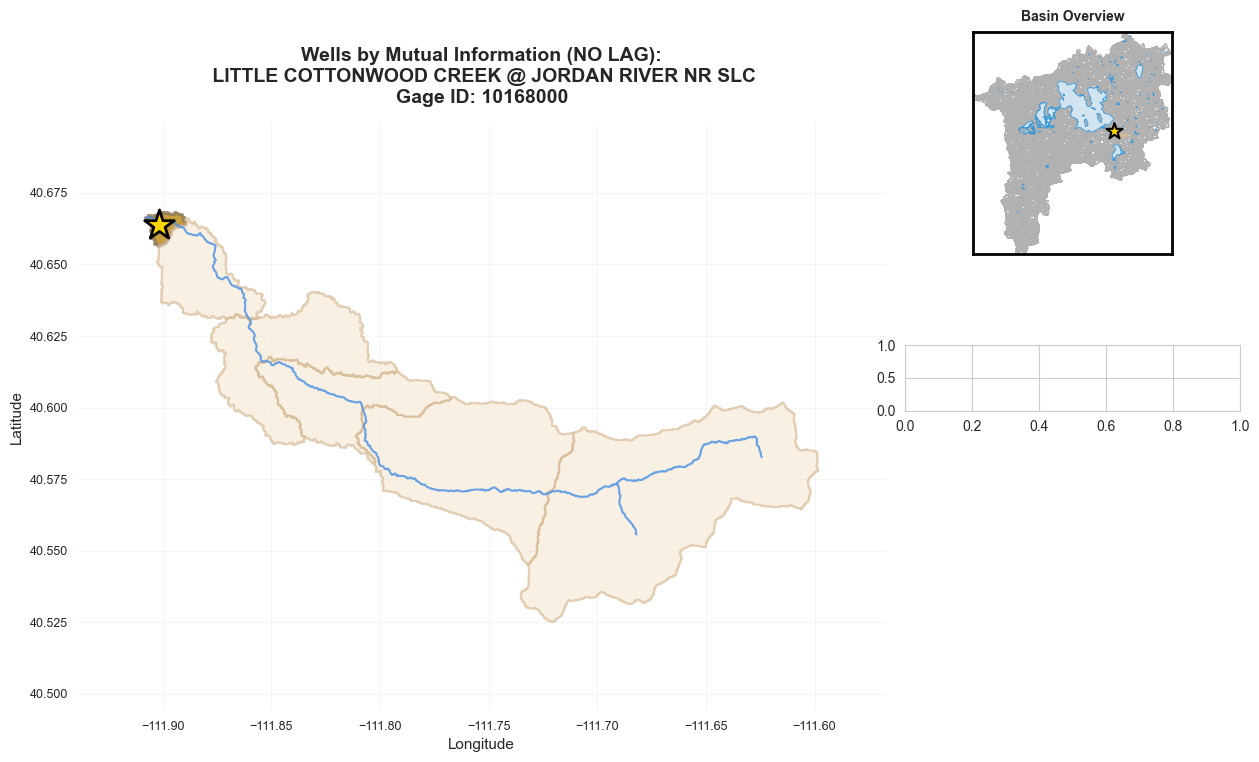

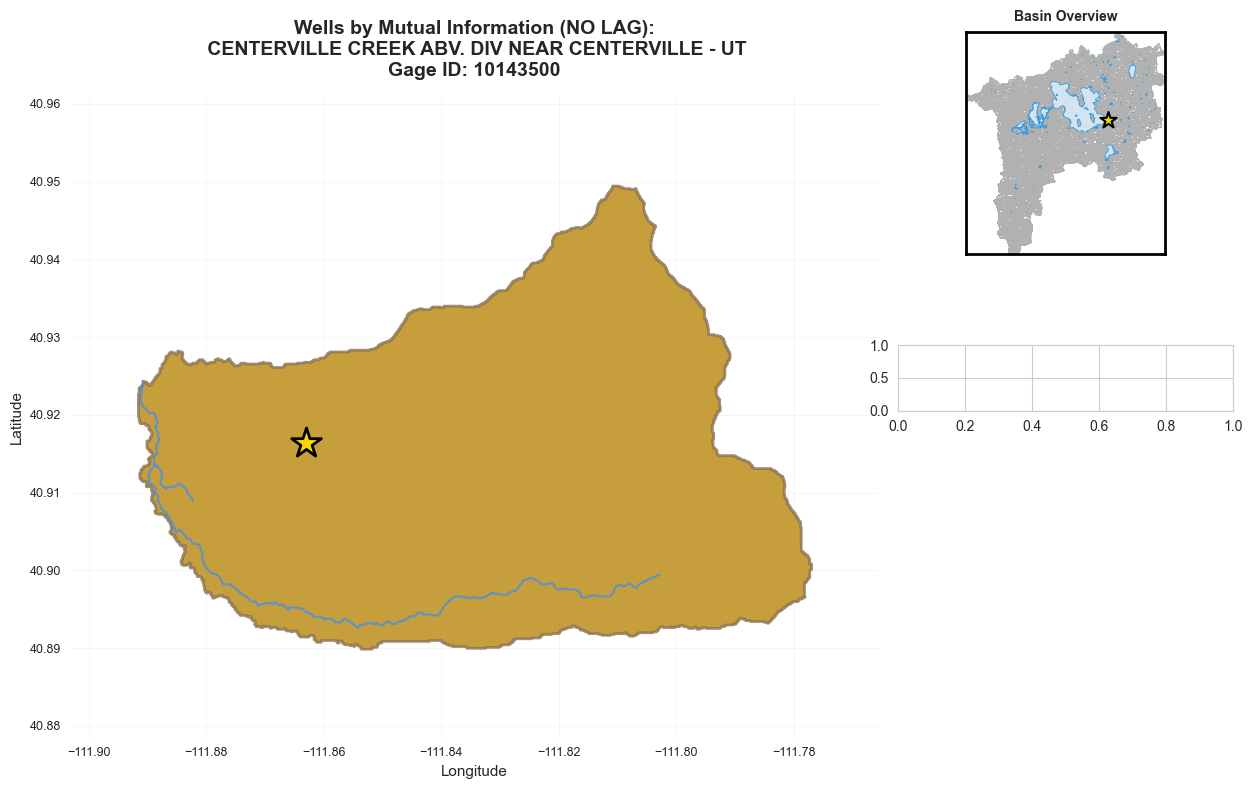

In [54]:
# Watershed MI mapping (NO LAG) — wells colored by mi_delta_wte_delta_q
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def create_watershed_mi_maps_no_lag():
    """
    Create watershed maps for each gage (no-lag version, same styling as correlation maps).
    Colors wells by mutual information (mi_delta_wte_delta_q).
    Saves to ../reports/figures/mi_no_lag
    """
    print("=== Creating Watershed MI Maps (NO LAG, Styled Version) ===")
    save_dir = "../reports/figures/mi_no_lag"
    os.makedirs(save_dir, exist_ok=True)

    # -----------------------------
    # Load geographic datasets
    # -----------------------------
    print("Loading datasets...")
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    stream_gdf   = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf     = gpd.read_file('../data/raw/hydrography/lake.shp')
    gage_df      = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

    # Support tables for joining well geometry
    reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv')
    well_locations  = pd.read_csv('../data/processed/well_reach.csv')[['well_id', 'well_lat', 'well_lon']].drop_duplicates()

    # -----------------------------
    # NO-LAG well–gage MI data (edit the path if your filename differs)
    # -----------------------------
    no_lag_mi_path = '../data/features/well_gage_mi_no_lag.csv'
    no_lag_mi = pd.read_csv(no_lag_mi_path)
    # Expecting columns:
    # well_id, gage_id, mi_delta_wte_delta_q, pearson_r, spearman_r, n_records
    no_lag_mi = no_lag_mi[['well_id', 'gage_id', 'mi_delta_wte_delta_q']].dropna().drop_duplicates()

    # gage_id integer
    no_lag_mi['gage_id'] = no_lag_mi['gage_id'].astype(int)
    print(f"Using NO-LAG MI data for well-gage relationships: {len(no_lag_mi)} unique pairs")

    # -----------------------------
    # Upstream relationships (optional)
    # -----------------------------
    try:
        terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
        print("✅ Loaded terminal relationships")
    except FileNotFoundError:
        print("⚠️ Terminal relationships file not found, using simplified extent")
        terminal_relationships = None

    print("✅ All datasets loaded")

    # -----------------------------
    # Merge data using numeric IDs
    # -----------------------------
    print("Merging data...")
    reach_distances['well_id_numeric'] = pd.to_numeric(reach_distances['Well_ID'], errors='coerce')
    well_locations['well_id_numeric']  = pd.to_numeric(well_locations['well_id'], errors='coerce')
    no_lag_mi['well_id_numeric']       = pd.to_numeric(no_lag_mi['well_id'], errors='coerce')

    merge1 = pd.merge(reach_distances, well_locations, on='well_id_numeric', how='inner')
    print(f"After adding coordinates: {len(merge1)} wells")

    final_data = pd.merge(merge1, no_lag_mi, on='well_id_numeric', how='inner')
    print(f"Final merged data: {len(final_data)} wells with gage relationships")

    if len(final_data) == 0:
        print("❌ No data after merging - cannot create maps")
        return

    # Ensure CRS
    subbasin_gdf = subbasin_gdf.to_crs("EPSG:4326")
    stream_gdf   = stream_gdf.to_crs("EPSG:4326")
    lake_gdf     = lake_gdf.to_crs("EPSG:4326")

    # Unique gages to map
    unique_gages = final_data['gage_id'].dropna().unique()
    print(f"Creating maps for {len(unique_gages)} gages: {unique_gages}")

    for gage_id in tqdm(unique_gages, desc="Creating NO-LAG MI maps"):
        try:
            gage_wells = final_data[final_data['gage_id'] == gage_id].copy()
            if len(gage_wells) == 0:
                continue
            create_single_styled_map_mi_no_lag(
                gage_id, gage_wells, subbasin_gdf, stream_gdf,
                lake_gdf, gage_df, terminal_relationships, save_dir
            )
        except Exception as e:
            print(f"❌ Error for gage {gage_id}: {e}")
            import traceback
            traceback.print_exc()

    print(f"✅ Maps saved to: {save_dir}")

def get_gage_watersheds_styled(gage_id, subbasin_gdf, gage_df, terminal_relationships=None):
    """Get terminal and upstream basins for a gage - styled version (shared)."""
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs), gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    gage_point = Point(gage_lon, gage_lat)
    gage_gdf = gpd.GeoDataFrame([1], geometry=[gage_point], crs="EPSG:4326")
    gage_gdf = gage_gdf.to_crs(subbasin_gdf.crs)
    gage_point = gage_gdf.geometry.iloc[0]

    containing = subbasin_gdf[subbasin_gdf.geometry.contains(gage_point)]
    if len(containing) > 0:
        terminal_basin = containing.iloc[[0]]
    else:
        distances = subbasin_gdf.geometry.distance(gage_point)
        terminal_basin = subbasin_gdf.iloc[[distances.idxmin()]]

    upstream_basins = gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    if terminal_relationships is not None:
        if 'Gage_ID' in terminal_relationships.columns:
            gage_col, upstream_col = 'Gage_ID', 'Upstream_Catchment_ID'
        else:
            gage_col, upstream_col = 'gage_id', 'upstream_catchment_id'

        linkno_col = None
        for col in ['linkno', 'LINKNO', 'LinkNo', 'LINK_NO']:
            if col in subbasin_gdf.columns:
                linkno_col = col
                break

        if linkno_col and gage_col in terminal_relationships.columns:
            upstream_catchments = terminal_relationships.loc[
                terminal_relationships[gage_col] == gage_id, upstream_col
            ].dropna().astype(int).tolist()

            if upstream_catchments:
                upstream_basins = subbasin_gdf[
                    subbasin_gdf[linkno_col].astype(int).isin(upstream_catchments)
                ].copy()

                if not terminal_basin.empty:
                    terminal_linkno = int(terminal_basin.iloc[0][linkno_col])
                    upstream_basins = upstream_basins[
                        upstream_basins[linkno_col].astype(int) != terminal_linkno
                    ]

    return terminal_basin, upstream_basins

def create_single_styled_map_mi_no_lag(gage_id, gage_wells, subbasin_gdf, stream_gdf, lake_gdf,
                                       gage_df, terminal_relationships, save_dir):
    """Create a single NO-LAG MI map, wells colored by mi_delta_wte_delta_q."""
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"No gage info for {gage_id}")
        return False

    gage_name = gage_info.iloc[0].get('name', f'Gage {gage_id}')
    gage_lat  = gage_info.iloc[0]['latitude']
    gage_lon  = gage_info.iloc[0]['longitude']

    terminal_basin, upstream_basins = get_gage_watersheds_styled(
        gage_id, subbasin_gdf, gage_df, terminal_relationships
    )
    if terminal_basin.empty:
        print(f"No terminal basin found for gage {gage_id}")
        return False

    # Sort wells by MI
    gage_wells = gage_wells.sort_values('mi_delta_wte_delta_q', ascending=False)

    # --- Figure layout (same as correlation maps)
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax_main = plt.subplot2grid((10, 10), (0, 0), colspan=7, rowspan=10)
    ax_main.set_facecolor('white')

    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax_main, color='#B8860B', alpha=0.8,
                            edgecolor='#8B7355', linewidth=2, zorder=1)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax_main, color='#F5E6D3', alpha=0.6,
                             edgecolor='#D2B48C', linewidth=1.5, zorder=1)

    # Clip base layers by watershed extent
    all_basins = pd.concat([terminal_basin, upstream_basins], ignore_index=True)
    if not all_basins.empty:
        watershed_union = all_basins.unary_union
        local_streams = stream_gdf[stream_gdf.geometry.intersects(watershed_union)]
        local_lakes   = lake_gdf[lake_gdf.geometry.intersects(watershed_union)]
    else:
        from shapely.geometry import box
        all_lons = [gage_lon] + gage_wells['well_lon'].tolist()
        all_lats = [gage_lat] + gage_wells['well_lat'].tolist()
        min_lon, max_lon = min(all_lons), max(all_lons)
        min_lat, max_lat = min(all_lats), max(all_lats)
        buffer = max(max_lon - min_lon, max_lat - min_lat) * 0.3 if (max_lon > min_lon and max_lat > min_lat) else 0.1
        extent_box = box(min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer)
        local_streams = stream_gdf[stream_gdf.geometry.intersects(extent_box)]
        local_lakes   = lake_gdf[lake_gdf.geometry.intersects(extent_box)]

    if not local_streams.empty:
        local_streams.plot(ax=ax_main, color='#4A90E2', linewidth=1.5, alpha=0.8, zorder=2)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax_main, color='#E6F3FF', alpha=0.8, edgecolor='#4A90E2', linewidth=0.8, zorder=2)

    # Scatter wells colored by MI (robust color range)
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        scatter = ax_main.scatter(
            gage_wells['well_lon'], gage_wells['well_lat'],
            c=gage_wells['mi_delta_wte_delta_q'],
            cmap='viridis', s=90, alpha=0.9,
            edgecolor='black', linewidth=0.8, zorder=4, norm=norm
        )

    # Gage star
    ax_main.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=500,
                    edgecolor='black', linewidth=2, zorder=10)

    # Extent
    if not all_basins.empty:
        bounds = all_basins.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax_main.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax_main.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    else:
        all_lons = list(gage_wells['well_lon']) + [gage_lon]
        all_lats = list(gage_wells['well_lat']) + [gage_lat]
        lon_buffer = (max(all_lons) - min(all_lons)) * 0.2
        lat_buffer = (max(all_lats) - min(all_lats)) * 0.2
        ax_main.set_xlim(min(all_lons) - lon_buffer, max(all_lons) + lon_buffer)
        ax_main.set_ylim(min(all_lats) - lat_buffer, max(all_lats) + lat_buffer)

    # Titles / axes
    ax_main.set_title(f'Wells by Mutual Information (NO LAG):\n {gage_name}\nGage ID: {gage_id}',
                      fontsize=14, fontweight='bold', pad=15)
    ax_main.set_xlabel('Longitude', fontsize=11)
    ax_main.set_ylabel('Latitude', fontsize=11)
    for spine in ax_main.spines.values():
        spine.set_visible(False)
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='lightgray')
    ax_main.tick_params(labelsize=9)

    # Inset
    ax_inset = plt.subplot2grid((10, 10), (0, 7), colspan=3, rowspan=3)
    ax_inset.set_facecolor('white')
    plot_overview_inset_styled(ax_inset, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id)

    # Colorbar
    if len(gage_wells) > 0:
        cbar_ax = plt.subplot2grid((10, 10), (4, 7), colspan=3, rowspan=1)
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Mutual Information (MI)', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=8)

    # Stats + legend
    add_mi_statistics_and_legend(fig, ax_main, gage_wells, gage_id, terminal_basin, upstream_basins)

    # Save
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:40]
    filename = f"gage_{int(gage_id)}_mi_no_lag_{safe_name}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', pad_inches=0.1)
    plt.close()
    print(f"✅ Saved map for gage {gage_id}: {filename}")
    return True

def plot_overview_inset_styled(ax, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id):
    """Overview inset (shared)."""
    subbasin_gdf.plot(ax=ax, color='#FAFAFA', edgecolor='#B0B0B0', linewidth=0.6, alpha=0.9)
    lake_gdf.plot(ax=ax, color='#D6EAF8', alpha=0.9, edgecolor='#3498DB', linewidth=0.6)

    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color='#CD853F', alpha=0.8, edgecolor='#8B7355', linewidth=1.5)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax, color='#F5E6D3', alpha=0.7, edgecolor='#D2B48C', linewidth=1.2)

    ax.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=150,
               edgecolor='black', linewidth=1.5, zorder=5)

    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

    ax.set_title('Basin Overview', fontsize=10, fontweight='bold', pad=8)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True); spine.set_linewidth(2); spine.set_edgecolor('black')
    ax.set_aspect('equal')

def add_mi_statistics_and_legend(fig, ax_main, gage_wells, gage_id,
                                 terminal_basin, upstream_basins):
    """Stats box + legend (MI version for NO LAG)."""
    watershed_info = ""
    if not terminal_basin.empty:
        watershed_info += "Terminal Basin: 1\n"
    if not upstream_basins.empty:
        watershed_info += f"Upstream Basins: {len(upstream_basins)}\n"

    wells_n = len(gage_wells) if gage_wells is not None else 0
    if wells_n > 0 and 'mi_delta_wte_delta_q' in gage_wells.columns:
        mi_series = gage_wells['mi_delta_wte_delta_q'].astype(float)
        mi_series = mi_series.replace([np.inf, -np.inf], np.nan).dropna()
        if len(mi_series) > 0:
            min_mi  = np.nanmin(mi_series)
            mean_mi = np.nanmean(mi_series)
            p90_mi  = np.nanpercentile(mi_series, 90)
            max_mi  = np.nanmax(mi_series)
            stats_text = (
                f"{watershed_info}"
                f"Wells: {wells_n}\n"
                f"Min MI:  {min_mi:.3f}\n"
                f"Mean MI: {mean_mi:.3f}\n"
                f"P90 MI:  {p90_mi:.3f}\n"
                f"Max MI:  {max_mi:.3f}"
            )
        else:
            stats_text = f"{watershed_info}Wells: {wells_n}\nNo valid MI values"
    else:
        stats_text = f"{watershed_info}Wells: {wells_n}\nNo MI column"

    ax_main.text(
        0.02, 0.98, stats_text, transform=ax_main.transAxes,
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                  alpha=0.95, edgecolor='black', linewidth=1),
        verticalalignment='top', fontsize=10, fontweight='bold', zorder=15
    )

    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w',
                   markerfacecolor='#FFD700', markersize=18,
                   markeredgecolor='black', markeredgewidth=1.5,
                   label=f'Gage {int(gage_id)}', linestyle='None'),
    ]
    if not terminal_basin.empty:
        legend_elements.append(
            plt.Rectangle((0,0), 1,1, facecolor='#B8860B', edgecolor='#8B7355',
                          alpha=0.8, label='Terminal Basin (Gage Location)')
        )
    if not upstream_basins.empty:
        legend_elements.append(
            plt.Rectangle((0,0), 1,1, facecolor='#F5E6D3', edgecolor='#D2B48C',
                          alpha=0.6, label='Upstream Basins')
        )

    ax_main.legend(handles=legend_elements, loc='lower left',
                   bbox_to_anchor=(0.02, 0.02), fontsize=9,
                   frameon=True, fancybox=False, shadow=False,
                   edgecolor='black', facecolor='white', framealpha=0.95)

# Run
create_watershed_mi_maps_no_lag()


## delta lag

In [42]:
delta_mi = pd.read_csv('../data/processed/mi_compare_lag_vs_no_lag_by_pair.csv')
delta_mi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   well_id           879 non-null    int64  
 1   gage_id           879 non-null    int64  
 2   mi_no_lag         879 non-null    float64
 3   pearson_no_lag    878 non-null    float64
 4   spearman_no_lag   878 non-null    float64
 5   n_records_no_lag  879 non-null    float64
 6   mi_lag            863 non-null    float64
 7   pearson_lag       871 non-null    float64
 8   spearman_lag      871 non-null    float64
 9   n_records_lag     879 non-null    float64
 10  delta_mi          863 non-null    float64
 11  ratio_mi          863 non-null    float64
 12  nl_gain_lag       861 non-null    float64
 13  nl_gain_no_lag    878 non-null    float64
 14  delta_nl_gain     861 non-null    float64
dtypes: float64(13), int64(2)
memory usage: 103.1 KB


In [50]:
# Watershed ΔMI mapping (LAG - NO LAG) — wells colored by delta_mi
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def create_watershed_mi_delta_maps():
    """
    Create watershed maps for each gage (ΔMI version).
    Colors wells by delta_mi (mi_lag - mi_no_lag).
    Saves to ../reports/figures/mi_delta
    """
    print("=== Creating Watershed ΔMI Maps (Styled Version) ===")
    save_dir = "../reports/figures/mi_delta"
    os.makedirs(save_dir, exist_ok=True)

    # -----------------------------
    # Load geographic datasets
    # -----------------------------
    print("Loading datasets...")
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    stream_gdf   = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf     = gpd.read_file('../data/raw/hydrography/lake.shp')
    gage_df      = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

    # Support tables for joining well geometry
    reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv')
    well_locations  = pd.read_csv('../data/processed/well_reach.csv')[['well_id', 'well_lat', 'well_lon']].drop_duplicates()

    # -----------------------------
    # ΔMI well–gage data
    # -----------------------------
    delta_mi_df = pd.read_csv('../data/processed/mi_compare_lag_vs_no_lag_by_pair.csv')

    # Expecting columns like:
    # well_id, gage_id, mi_no_lag, mi_lag, delta_mi, ratio_mi, ...
    delta_mi_df = delta_mi_df[['well_id', 'gage_id', 'delta_mi']].dropna().drop_duplicates()
    delta_mi_df['gage_id'] = delta_mi_df['gage_id'].astype(int)

    print(f"Using ΔMI data for well-gage relationships: {len(delta_mi_df)} unique pairs")

    # -----------------------------
    # Upstream relationships (optional)
    # -----------------------------
    try:
        terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
        print("✅ Loaded terminal relationships")
    except FileNotFoundError:
        print("⚠️ Terminal relationships file not found, using simplified extent")
        terminal_relationships = None

    print("✅ All datasets loaded")

    # -----------------------------
    # Merge data using numeric IDs
    # -----------------------------
    print("Merging data...")
    reach_distances['well_id_numeric'] = pd.to_numeric(reach_distances['Well_ID'], errors='coerce')
    well_locations['well_id_numeric']  = pd.to_numeric(well_locations['well_id'], errors='coerce')
    delta_mi_df['well_id_numeric']     = pd.to_numeric(delta_mi_df['well_id'], errors='coerce')

    merge1 = pd.merge(reach_distances, well_locations, on='well_id_numeric', how='inner')
    print(f"After adding coordinates: {len(merge1)} wells")

    final_data = pd.merge(merge1, delta_mi_df, on='well_id_numeric', how='inner')
    print(f"Final merged data: {len(final_data)} wells with gage relationships")

    if len(final_data) == 0:
        print("❌ No data after merging - cannot create maps")
        return

    # Ensure CRS
    subbasin_gdf = subbasin_gdf.to_crs("EPSG:4326")
    stream_gdf   = stream_gdf.to_crs("EPSG:4326")
    lake_gdf     = lake_gdf.to_crs("EPSG:4326")

    # Unique gages to map
    unique_gages = final_data['gage_id'].dropna().unique()
    print(f"Creating maps for {len(unique_gages)} gages: {unique_gages}")

    for gage_id in tqdm(unique_gages, desc="Creating ΔMI maps"):
        try:
            gage_wells = final_data[final_data['gage_id'] == gage_id].copy()
            if len(gage_wells) == 0:
                continue
            create_single_styled_map_mi_delta(
                gage_id, gage_wells, subbasin_gdf, stream_gdf,
                lake_gdf, gage_df, terminal_relationships, save_dir
            )
        except Exception as e:
            print(f"❌ Error for gage {gage_id}: {e}")
            import traceback
            traceback.print_exc()

    print(f"✅ Maps saved to: {save_dir}")

def get_gage_watersheds_styled(gage_id, subbasin_gdf, gage_df, terminal_relationships=None):
    """Get terminal and upstream basins for a gage - styled version (shared)."""
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs), gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    gage_point = Point(gage_lon, gage_lat)
    gage_gdf = gpd.GeoDataFrame([1], geometry=[gage_point], crs="EPSG:4326")
    gage_gdf = gage_gdf.to_crs(subbasin_gdf.crs)
    gage_point = gage_gdf.geometry.iloc[0]

    containing = subbasin_gdf[subbasin_gdf.geometry.contains(gage_point)]
    if len(containing) > 0:
        terminal_basin = containing.iloc[[0]]
    else:
        distances = subbasin_gdf.geometry.distance(gage_point)
        terminal_basin = subbasin_gdf.iloc[[distances.idxmin()]]

    upstream_basins = gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    if terminal_relationships is not None:
        if 'Gage_ID' in terminal_relationships.columns:
            gage_col, upstream_col = 'Gage_ID', 'Upstream_Catchment_ID'
        else:
            gage_col, upstream_col = 'gage_id', 'upstream_catchment_id'

        linkno_col = None
        for col in ['linkno', 'LINKNO', 'LinkNo', 'LINK_NO']:
            if col in subbasin_gdf.columns:
                linkno_col = col
                break

        if linkno_col and gage_col in terminal_relationships.columns:
            upstream_catchments = terminal_relationships.loc[
                terminal_relationships[gage_col] == gage_id, upstream_col
            ].dropna().astype(int).tolist()

            if upstream_catchments:
                upstream_basins = subbasin_gdf[
                    subbasin_gdf[linkno_col].astype(int).isin(upstream_catchments)
                ].copy()

                if not terminal_basin.empty:
                    terminal_linkno = int(terminal_basin.iloc[0][linkno_col])
                    upstream_basins = upstream_basins[
                        upstream_basins[linkno_col].astype(int) != terminal_linkno
                    ]

    return terminal_basin, upstream_basins

def create_single_styled_map_mi_delta(gage_id, gage_wells, subbasin_gdf, stream_gdf, lake_gdf,
                                      gage_df, terminal_relationships, save_dir):
    """Create a single ΔMI map, wells colored by delta_mi."""
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"No gage info for {gage_id}")
        return False

    gage_name = gage_info.iloc[0].get('name', f'Gage {gage_id}')
    gage_lat  = gage_info.iloc[0]['latitude']
    gage_lon  = gage_info.iloc[0]['longitude']

    terminal_basin, upstream_basins = get_gage_watersheds_styled(
        gage_id, subbasin_gdf, gage_df, terminal_relationships
    )
    if terminal_basin.empty:
        print(f"No terminal basin found for gage {gage_id}")
        return False

    # Sort wells by ΔMI
    gage_wells = gage_wells.sort_values('delta_mi', ascending=False)

    # --- Figure layout
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax_main = plt.subplot2grid((10, 10), (0, 0), colspan=7, rowspan=10)
    ax_main.set_facecolor('white')

    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax_main, color='#B8860B', alpha=0.8,
                            edgecolor='#8B7355', linewidth=2, zorder=1)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax_main, color='#F5E6D3', alpha=0.6,
                             edgecolor='#D2B48C', linewidth=1.5, zorder=1)

    # Clip base layers by watershed extent
    all_basins = pd.concat([terminal_basin, upstream_basins], ignore_index=True)
    if not all_basins.empty:
        watershed_union = all_basins.unary_union
        local_streams = stream_gdf[stream_gdf.geometry.intersects(watershed_union)]
        local_lakes   = lake_gdf[lake_gdf.geometry.intersects(watershed_union)]
    else:
        from shapely.geometry import box
        all_lons = [gage_lon] + gage_wells['well_lon'].tolist()
        all_lats = [gage_lat] + gage_wells['well_lat'].tolist()
        min_lon, max_lon = min(all_lons), max(all_lons)
        min_lat, max_lat = min(all_lats), max(all_lats)
        buffer = max(max_lon - min_lon, max_lat - min_lat) * 0.3 if (max_lon > min_lon and max_lat > min_lat) else 0.1
        extent_box = box(min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer)
        local_streams = stream_gdf[stream_gdf.geometry.intersects(extent_box)]
        local_lakes   = lake_gdf[lake_gdf.geometry.intersects(extent_box)]

    if not local_streams.empty:
        local_streams.plot(ax=ax_main, color='#4A90E2', linewidth=1.5, alpha=0.8, zorder=2)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax_main, color='#E6F3FF', alpha=0.8, edgecolor='#4A90E2', linewidth=0.8, zorder=2)

    # Scatter wells colored by ΔMI (robust color range, diverging colormap)
    if len(gage_wells) > 0:
        dmi_vals = gage_wells['delta_mi'].astype(float).replace([np.inf, -np.inf], np.nan)
        # Use symmetric robust limits around zero
        p = 95
        vmax = np.nanpercentile(np.abs(dmi_vals), p)
        vlim = float(vmax) if np.isfinite(vmax) and vmax > 0 else float(np.nanmax(np.abs(dmi_vals)))
        if not np.isfinite(vlim) or vlim == 0:
            vlim = 1e-6
        norm = plt.Normalize(vmin=-dmi_abs_max, vmax=dmi_abs_max)

        scatter = ax_main.scatter(
            gage_wells['well_lon'], gage_wells['well_lat'],
            c=gage_wells['delta_mi'],
            cmap='coolwarm',  # diverging: blue(−) → red(+)
            s=90, alpha=0.9, edgecolor='black', linewidth=0.8, zorder=4, norm=norm
        )

    # Gage star
    ax_main.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=500,
                    edgecolor='black', linewidth=2, zorder=10)

    # Extent
    if not all_basins.empty:
        bounds = all_basins.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax_main.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax_main.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    else:
        all_lons = list(gage_wells['well_lon']) + [gage_lon]
        all_lats = list(gage_wells['well_lat']) + [gage_lat]
        lon_buffer = (max(all_lons) - min(all_lons)) * 0.2
        lat_buffer = (max(all_lats) - min(all_lats)) * 0.2
        ax_main.set_xlim(min(all_lons) - lon_buffer, max(all_lons) + lon_buffer)
        ax_main.set_ylim(min(all_lats) - lat_buffer, max(all_lats) + lat_buffer)

    # Titles / axes
    ax_main.set_title(f'Wells by ΔMI (Lag − No-lag):\n {gage_name}\nGage ID: {gage_id}',
                      fontsize=14, fontweight='bold', pad=15)
    ax_main.set_xlabel('Longitude', fontsize=11)
    ax_main.set_ylabel('Latitude', fontsize=11)
    for spine in ax_main.spines.values():
        spine.set_visible(False)
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='lightgray')
    ax_main.tick_params(labelsize=9)

    # Inset
    ax_inset = plt.subplot2grid((10, 10), (0, 7), colspan=3, rowspan=3)
    ax_inset.set_facecolor('white')
    plot_overview_inset_styled(ax_inset, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id)

    # Colorbar
    if len(gage_wells) > 0:
        cbar_ax = plt.subplot2grid((10, 10), (4, 7), colspan=3, rowspan=1)
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('ΔMI (Lag − No lag)', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=8)

    # Stats + legend
    add_delta_mi_statistics_and_legend(fig, ax_main, gage_wells, gage_id, terminal_basin, upstream_basins)

    # Save
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:40]
    filename = f"gage_{int(gage_id)}_delta_mi_{safe_name}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', pad_inches=0.1)
    plt.close()
    print(f"✅ Saved map for gage {gage_id}: {filename}")
    return True

def plot_overview_inset_styled(ax, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id):
    """Overview inset (shared)."""
    subbasin_gdf.plot(ax=ax, color='#FAFAFA', edgecolor='#B0B0B0', linewidth=0.6, alpha=0.9)
    lake_gdf.plot(ax=ax, color='#D6EAF8', alpha=0.9, edgecolor='#3498DB', linewidth=0.6)

    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color='#CD853F', alpha=0.8, edgecolor='#8B7355', linewidth=1.5)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax, color='#F5E6D3', alpha=0.7, edgecolor='#D2B48C', linewidth=1.2)

    ax.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=150,
               edgecolor='black', linewidth=1.5, zorder=5)

    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

    ax.set_title('Basin Overview', fontsize=10, fontweight='bold', pad=8)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True); spine.set_linewidth(2); spine.set_edgecolor('black')
    ax.set_aspect('equal')

def add_delta_mi_statistics_and_legend(fig, ax_main, gage_wells, gage_id,
                                       terminal_basin, upstream_basins):
    """Stats box + legend (ΔMI version)."""
    watershed_info = ""
    if not terminal_basin.empty:
        watershed_info += "Terminal Basin: 1\n"
    if not upstream_basins.empty:
        watershed_info += f"Upstream Basins: {len(upstream_basins)}\n"

    wells_n = len(gage_wells) if gage_wells is not None else 0
    if wells_n > 0 and 'delta_mi' in gage_wells.columns:
        dmi = gage_wells['delta_mi'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if len(dmi) > 0:
            min_d  = float(np.nanmin(dmi))
            mean_d = float(np.nanmean(dmi))
            p90_d  = float(np.nanpercentile(dmi, 90))
            max_d  = float(np.nanmax(dmi))
            pos_pct = 100.0 * float(np.mean(dmi > 0))

            stats_text = (
                f"{watershed_info}"
                f"Wells: {wells_n}\n"
                f"Min ΔMI:  {min_d:.3f}\n"
                f"Mean ΔMI: {mean_d:.3f}\n"
                f"P90 ΔMI:  {p90_d:.3f}\n"
                f"Max ΔMI:  {max_d:.3f}\n"
                f"% ΔMI>0:  {pos_pct:.1f}%"
            )
        else:
            stats_text = f"{watershed_info}Wells: {wells_n}\nNo valid ΔMI values"
    else:
        stats_text = f"{watershed_info}Wells: {wells_n}\nNo ΔMI column"

    ax_main.text(
        0.02, 0.98, stats_text, transform=ax_main.transAxes,
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                  alpha=0.95, edgecolor='black', linewidth=1),
        verticalalignment='top', fontsize=10, fontweight='bold', zorder=15
    )

    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w',
                   markerfacecolor='#FFD700', markersize=18,
                   markeredgecolor='black', markeredgewidth=1.5,
                   label=f'Gage {int(gage_id)}', linestyle='None'),
    ]
    if not terminal_basin.empty:
        legend_elements.append(
            plt.Rectangle((0,0), 1,1, facecolor='#B8860B', edgecolor='#8B7355',
                          alpha=0.8, label='Terminal Basin (Gage Location)')
        )
    if not upstream_basins.empty:
        legend_elements.append(
            plt.Rectangle((0,0), 1,1, facecolor='#F5E6D3', edgecolor='#D2B48C',
                          alpha=0.6, label='Upstream Basins')
        )

    ax_main.legend(handles=legend_elements, loc='lower left',
                   bbox_to_anchor=(0.02, 0.02), fontsize=9,
                   frameon=True, fancybox=False, shadow=False,
                   edgecolor='black', facecolor='white', framealpha=0.95)

# Run
create_watershed_mi_delta_maps()


=== Creating Watershed ΔMI Maps (Styled Version) ===
Loading datasets...
Using ΔMI data for well-gage relationships: 863 unique pairs
✅ Loaded terminal relationships
✅ All datasets loaded
Merging data...
After adding coordinates: 8752 wells
Final merged data: 863 wells with gage relationships
Creating maps for 6 gages: [10152000 10141000 10163000 10168000 10143500 10126000]


Creating ΔMI maps:  17%|█▋        | 1/6 [00:20<01:44, 20.84s/it]

✅ Saved map for gage 10152000: gage_10152000_delta_mi_SPANISH FORK NEAR LAKE SHORE - UTAH.png


Creating ΔMI maps:  33%|███▎      | 2/6 [00:43<01:28, 22.12s/it]

✅ Saved map for gage 10141000: gage_10141000_delta_mi_WEBER RIVER NEAR PLAIN CITY - UT.png


Creating ΔMI maps:  50%|█████     | 3/6 [01:04<01:04, 21.41s/it]

✅ Saved map for gage 10163000: gage_10163000_delta_mi_PROVO RIVER AT PROVO - UT.png


Creating ΔMI maps:  67%|██████▋   | 4/6 [01:23<00:41, 20.62s/it]

✅ Saved map for gage 10168000: gage_10168000_delta_mi_LITTLE COTTONWOOD CREEK @ JORDAN RIVER N.png


Creating ΔMI maps:  83%|████████▎ | 5/6 [01:41<00:19, 19.40s/it]

✅ Saved map for gage 10143500: gage_10143500_delta_mi_CENTERVILLE CREEK ABV. DIV NEAR CENTERVI.png


Creating ΔMI maps: 100%|██████████| 6/6 [02:15<00:00, 22.52s/it]

✅ Saved map for gage 10126000: gage_10126000_delta_mi_BEAR RIVER NEAR CORINNE - UT.png
✅ Maps saved to: ../reports/figures/mi_delta


In [56]:
# Watershed ΔMI mapping (LAG - NO LAG) — wells colored by delta_mi
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

def create_watershed_mi_delta_maps():
    """
    Create watershed maps for each gage (ΔMI version).
    Colors wells by delta_mi (mi_lag - mi_no_lag).
    Saves to ../reports/figures/mi_delta
    """
    print("=== Creating Watershed ΔMI Maps (Styled Version) ===")
    save_dir = "../reports/figures/mi_delta_top10"
    os.makedirs(save_dir, exist_ok=True)

    # -----------------------------
    # Load geographic datasets
    # -----------------------------
    print("Loading datasets...")
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    stream_gdf   = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf     = gpd.read_file('../data/raw/hydrography/lake.shp')
    gage_df      = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')

    # Support tables for joining well geometry
    reach_distances = pd.read_csv('../data/processed/well_reach_relationships_final.csv')
    well_locations  = pd.read_csv('../data/processed/well_reach.csv')[['well_id', 'well_lat', 'well_lon']].drop_duplicates()

    # -----------------------------
    # ΔMI well–gage data
    # -----------------------------
    delta_mi_df = pd.read_csv('../data/processed/mi_compare_lag_vs_no_lag_by_pair.csv')

    # Expecting columns like:
    # well_id, gage_id, mi_no_lag, mi_lag, delta_mi, ratio_mi, ...
    delta_mi_df = delta_mi_df[['well_id', 'gage_id', 'delta_mi']].dropna().drop_duplicates()
    delta_mi_df['gage_id'] = delta_mi_df['gage_id'].astype(int)

    print(f"Using ΔMI data for well-gage relationships: {len(delta_mi_df)} unique pairs")

    # -----------------------------
    # Upstream relationships (optional)
    # -----------------------------
    try:
        terminal_relationships = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
        print("✅ Loaded terminal relationships")
    except FileNotFoundError:
        print("⚠️ Terminal relationships file not found, using simplified extent")
        terminal_relationships = None

    print("✅ All datasets loaded")

    # -----------------------------
    # Merge data using numeric IDs
    # -----------------------------
    print("Merging data...")
    reach_distances['well_id_numeric'] = pd.to_numeric(reach_distances['Well_ID'], errors='coerce')
    well_locations['well_id_numeric']  = pd.to_numeric(well_locations['well_id'], errors='coerce')
    delta_mi_df['well_id_numeric']     = pd.to_numeric(delta_mi_df['well_id'], errors='coerce')

    merge1 = pd.merge(reach_distances, well_locations, on='well_id_numeric', how='inner')
    print(f"After adding coordinates: {len(merge1)} wells")

    final_data = pd.merge(merge1, delta_mi_df, on='well_id_numeric', how='inner')
    print(f"Final merged data: {len(final_data)} wells with gage relationships")

    if len(final_data) == 0:
        print("❌ No data after merging - cannot create maps")
        return

    # Ensure CRS
    subbasin_gdf = subbasin_gdf.to_crs("EPSG:4326")
    stream_gdf   = stream_gdf.to_crs("EPSG:4326")
    lake_gdf     = lake_gdf.to_crs("EPSG:4326")

    # Unique gages to map
    unique_gages = final_data['gage_id'].dropna().unique()
    print(f"Creating maps for {len(unique_gages)} gages: {unique_gages}")

    for gage_id in tqdm(unique_gages, desc="Creating ΔMI maps"):
        try:
            gage_wells = final_data[final_data['gage_id'] == gage_id].copy()
            if len(gage_wells) == 0:
                continue
            create_single_styled_map_mi_delta(
                gage_id, gage_wells, subbasin_gdf, stream_gdf,
                lake_gdf, gage_df, terminal_relationships, save_dir
            )
        except Exception as e:
            print(f"❌ Error for gage {gage_id}: {e}")
            import traceback
            traceback.print_exc()

    print(f"✅ Maps saved to: {save_dir}")

def get_gage_watersheds_styled(gage_id, subbasin_gdf, gage_df, terminal_relationships=None):
    """Get terminal and upstream basins for a gage - styled version (shared)."""
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        return gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs), gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    gage_lat = gage_info.iloc[0]['latitude']
    gage_lon = gage_info.iloc[0]['longitude']

    gage_point = Point(gage_lon, gage_lat)
    gage_gdf = gpd.GeoDataFrame([1], geometry=[gage_point], crs="EPSG:4326")
    gage_gdf = gage_gdf.to_crs(subbasin_gdf.crs)
    gage_point = gage_gdf.geometry.iloc[0]

    containing = subbasin_gdf[subbasin_gdf.geometry.contains(gage_point)]
    if len(containing) > 0:
        terminal_basin = containing.iloc[[0]]
    else:
        distances = subbasin_gdf.geometry.distance(gage_point)
        terminal_basin = subbasin_gdf.iloc[[distances.idxmin()]]

    upstream_basins = gpd.GeoDataFrame(geometry=[], crs=subbasin_gdf.crs)

    if terminal_relationships is not None:
        if 'Gage_ID' in terminal_relationships.columns:
            gage_col, upstream_col = 'Gage_ID', 'Upstream_Catchment_ID'
        else:
            gage_col, upstream_col = 'gage_id', 'upstream_catchment_id'

        linkno_col = None
        for col in ['linkno', 'LINKNO', 'LinkNo', 'LINK_NO']:
            if col in subbasin_gdf.columns:
                linkno_col = col
                break

        if linkno_col and gage_col in terminal_relationships.columns:
            upstream_catchments = terminal_relationships.loc[
                terminal_relationships[gage_col] == gage_id, upstream_col
            ].dropna().astype(int).tolist()

            if upstream_catchments:
                upstream_basins = subbasin_gdf[
                    subbasin_gdf[linkno_col].astype(int).isin(upstream_catchments)
                ].copy()

                if not terminal_basin.empty:
                    terminal_linkno = int(terminal_basin.iloc[0][linkno_col])
                    upstream_basins = upstream_basins[
                        upstream_basins[linkno_col].astype(int) != terminal_linkno
                    ]

    return terminal_basin, upstream_basins

def create_single_styled_map_mi_delta(gage_id, gage_wells, subbasin_gdf, stream_gdf, lake_gdf,
                                      gage_df, terminal_relationships, save_dir,
                                      dmi_abs_max_global=None):
    """
    Create a single ΔMI map, wells colored by delta_mi, and annotate the top-10 wells
    by absolute change |delta_mi| with callouts (arrow + label box).

    Parameters
    ----------
    gage_id : int
    gage_wells : DataFrame
        Must contain columns: ['well_lon','well_lat','delta_mi', 'well_id']
    dmi_abs_max_global : float or None
        If provided, use this as symmetric color scale ±dmi_abs_max_global; otherwise
        compute from current gage_wells (robust ±95%).
    """
    # ---- gage info
    gage_info = gage_df[gage_df['id'] == gage_id]
    if gage_info.empty:
        print(f"No gage info for {gage_id}")
        return False

    gage_name = gage_info.iloc[0].get('name', f'Gage {gage_id}')
    gage_lat  = gage_info.iloc[0]['latitude']
    gage_lon  = gage_info.iloc[0]['longitude']

    # ---- watersheds
    terminal_basin, upstream_basins = get_gage_watersheds_styled(
        gage_id, subbasin_gdf, gage_df, terminal_relationships
    )
    if terminal_basin.empty:
        print(f"No terminal basin found for gage {gage_id}")
        return False

    # ---- sort for plotting (largest positive first is fine, we will select by abs below)
    gage_wells = gage_wells.copy()
    gage_wells = gage_wells.sort_values('delta_mi', ascending=False)

    # ---- figure layout
    fig = plt.figure(figsize=(15, 10))
    fig.patch.set_facecolor('white')
    ax_main = plt.subplot2grid((10, 10), (0, 0), colspan=7, rowspan=10)
    ax_main.set_facecolor('white')

    # polygons
    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax_main, color='#B8860B', alpha=0.8,
                            edgecolor='#8B7355', linewidth=2, zorder=1)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax_main, color='#F5E6D3', alpha=0.6,
                             edgecolor='#D2B48C', linewidth=1.5, zorder=1)

    # clip base layers
    all_basins = pd.concat([terminal_basin, upstream_basins], ignore_index=True)
    if not all_basins.empty:
        watershed_union = all_basins.unary_union
        local_streams = stream_gdf[stream_gdf.geometry.intersects(watershed_union)]
        local_lakes   = lake_gdf[lake_gdf.geometry.intersects(watershed_union)]
    else:
        from shapely.geometry import box
        all_lons = [gage_lon] + gage_wells['well_lon'].tolist()
        all_lats = [gage_lat] + gage_wells['well_lat'].tolist()
        min_lon, max_lon = min(all_lons), max(all_lons)
        min_lat, max_lat = min(all_lats), max(all_lats)
        buffer = max(max_lon - min_lon, max_lat - min_lat) * 0.3 if (max_lon > min_lon and max_lat > min_lat) else 0.1
        extent_box = box(min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer)
        local_streams = stream_gdf[stream_gdf.geometry.intersects(extent_box)]
        local_lakes   = lake_gdf[lake_gdf.geometry.intersects(extent_box)]

    if not local_streams.empty:
        local_streams.plot(ax=ax_main, color='#4A90E2', linewidth=1.5, alpha=0.8, zorder=2)
    if not local_lakes.empty:
        local_lakes.plot(ax=ax_main, color='#E6F3FF', alpha=0.8, edgecolor='#4A90E2', linewidth=0.8, zorder=2)

    # ---- color normalization (global symmetric optional)
    dmi_vals = gage_wells['delta_mi'].astype(float).replace([np.inf, -np.inf], np.nan)
    if dmi_abs_max_global is not None and np.isfinite(dmi_abs_max_global) and dmi_abs_max_global > 0:
        vlim = float(dmi_abs_max_global)
    else:
        # robust symmetric scaling by local 95% percentile of |ΔMI|
        p = 95
        vmax = np.nanpercentile(np.abs(dmi_vals.dropna()), p) if dmi_vals.notna().any() else 1e-6
        vlim = float(vmax) if np.isfinite(vmax) and vmax > 0 else 1e-6
    norm = plt.Normalize(vmin=-vlim, vmax=vlim)

    # ---- scatter of wells
    scatter = None
    if len(gage_wells) > 0:
        scatter = ax_main.scatter(
            gage_wells['well_lon'], gage_wells['well_lat'],
            c=gage_wells['delta_mi'], cmap='coolwarm', norm=norm,
            s=90, alpha=0.9, edgecolor='black', linewidth=0.8, zorder=4
        )

    # ---- gage star
    ax_main.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=500,
                    edgecolor='black', linewidth=2, zorder=10)

    # ---- extent
    if not all_basins.empty:
        bounds = all_basins.total_bounds
        buffer = max(bounds[2] - bounds[0], bounds[3] - bounds[1]) * 0.1
        ax_main.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax_main.set_ylim(bounds[1] - buffer, bounds[3] + buffer)
    else:
        all_lons = list(gage_wells['well_lon']) + [gage_lon]
        all_lats = list(gage_wells['well_lat']) + [gage_lat]
        lon_buffer = (max(all_lons) - min(all_lons)) * 0.2
        lat_buffer = (max(all_lats) - min(all_lats)) * 0.2
        ax_main.set_xlim(min(all_lons) - lon_buffer, max(all_lons) + lon_buffer)
        ax_main.set_ylim(min(all_lats) - lat_buffer, max(all_lats) + lat_buffer)

    # ---- titles / axes
    ax_main.set_title(f'Wells by ΔMI (Lag − No-lag):\n {gage_name}\nGage ID: {gage_id}',
                      fontsize=14, fontweight='bold', pad=15)
    ax_main.set_xlabel('Longitude', fontsize=11)
    ax_main.set_ylabel('Latitude', fontsize=11)
    for spine in ax_main.spines.values():
        spine.set_visible(False)
    ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='lightgray')
    ax_main.tick_params(labelsize=9)

    # ---- inset
    ax_inset = plt.subplot2grid((10, 10), (0, 7), colspan=3, rowspan=3)
    ax_inset.set_facecolor('white')
    plot_overview_inset_styled(ax_inset, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id)

    # ---- colorbar
    if scatter is not None:
        cbar_ax = plt.subplot2grid((10, 10), (4, 7), colspan=3, rowspan=1)
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('ΔMI = MI(lag) − MI(no-lag)', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=8)

    # ---- annotate top-10 by |ΔMI|
    if len(gage_wells) > 0:
        # Clean NaN; requires well_lon/lat, delta_mi, well_id
        annot_df = gage_wells[['well_id_numeric', 'well_lon', 'well_lat', 'delta_mi']].dropna(subset=['well_lon','well_lat','delta_mi'])
        if len(annot_df) > 0:
            topN = min(10, len(annot_df))
            top_wells = annot_df.reindex(
                annot_df['delta_mi'].abs().sort_values(ascending=False).index
            ).head(topN)

            # Calculate offset, adaptive to map extent
            x0, x1 = ax_main.get_xlim()
            y0, y1 = ax_main.get_ylim()
            dx = (x1 - x0) * 0.05
            dy = (y1 - y0) * 0.05

            # A set of scattered offsets to minimize overlap
            offsets = [
                ( dx,  dy), (-dx,  dy), ( dx, -dy), (-dx, -dy),
                (2*dx,  0), (-2*dx, 0), (0,  2*dy), (0, -2*dy),
                (1.5*dx, -1.5*dy), (-1.5*dx, 1.5*dy)
            ]
            # Add bold outline circles to top wells
            ax_main.scatter(
                top_wells['well_lon'], top_wells['well_lat'],
                facecolors='none', edgecolors='black', linewidths=2.0,
                s=160, zorder=12
            )

            for i, (_, row) in enumerate(top_wells.iterrows()):
                ox, oy = offsets[i % len(offsets)]
                label = f"Well {int(row['well_id_numeric'])}\nΔMI={row['delta_mi']:.3f}"
                ax_main.annotate(
                    label,
                    xy=(row['well_lon'], row['well_lat']),             # anchor point
                    xytext=(row['well_lon'] + ox, row['well_lat'] + oy),  # label box
                    textcoords='data',
                    arrowprops=dict(arrowstyle="->", color='black', lw=1.2),
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"),
                    fontsize=8, zorder=20
                )

    # ---- stats + legend
    add_delta_mi_statistics_and_legend(fig, ax_main, gage_wells, gage_id, terminal_basin, upstream_basins)

    # ---- save
    safe_name = gage_name.replace('/', '_').replace('\\', '_')[:40]
    filename = f"gage_{int(gage_id)}_delta_mi_{safe_name}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', pad_inches=0.1)
    plt.close()
    print(f"✅ Saved map for gage {gage_id}: {filename}")
    return True


def plot_overview_inset_styled(ax, subbasin_gdf, stream_gdf, lake_gdf,
                               terminal_basin, upstream_basins, gage_lon, gage_lat, gage_id):
    """Overview inset (shared)."""
    subbasin_gdf.plot(ax=ax, color='#FAFAFA', edgecolor='#B0B0B0', linewidth=0.6, alpha=0.9)
    lake_gdf.plot(ax=ax, color='#D6EAF8', alpha=0.9, edgecolor='#3498DB', linewidth=0.6)

    if not terminal_basin.empty:
        terminal_basin.plot(ax=ax, color='#CD853F', alpha=0.8, edgecolor='#8B7355', linewidth=1.5)
    if not upstream_basins.empty:
        upstream_basins.plot(ax=ax, color='#F5E6D3', alpha=0.7, edgecolor='#D2B48C', linewidth=1.2)

    ax.scatter(gage_lon, gage_lat, color='#FFD700', marker='*', s=150,
               edgecolor='black', linewidth=1.5, zorder=5)

    basin_bounds = subbasin_gdf.total_bounds
    ax.set_xlim(basin_bounds[0], basin_bounds[2])
    ax.set_ylim(basin_bounds[1], basin_bounds[3])

    ax.set_title('Basin Overview', fontsize=10, fontweight='bold', pad=8)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True); spine.set_linewidth(2); spine.set_edgecolor('black')
    ax.set_aspect('equal')

def add_delta_mi_statistics_and_legend(fig, ax_main, gage_wells, gage_id,
                                       terminal_basin, upstream_basins):
    """Stats box + legend (ΔMI version)."""
    watershed_info = ""
    if not terminal_basin.empty:
        watershed_info += "Terminal Basin: 1\n"
    if not upstream_basins.empty:
        watershed_info += f"Upstream Basins: {len(upstream_basins)}\n"

    wells_n = len(gage_wells) if gage_wells is not None else 0
    if wells_n > 0 and 'delta_mi' in gage_wells.columns:
        dmi = gage_wells['delta_mi'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if len(dmi) > 0:
            min_d  = float(np.nanmin(dmi))
            mean_d = float(np.nanmean(dmi))
            p90_d  = float(np.nanpercentile(dmi, 90))
            max_d  = float(np.nanmax(dmi))
            pos_pct = 100.0 * float(np.mean(dmi > 0))

            stats_text = (
                f"{watershed_info}"
                f"Wells: {wells_n}\n"
                f"Min ΔMI:  {min_d:.3f}\n"
                f"Mean ΔMI: {mean_d:.3f}\n"
                f"P90 ΔMI:  {p90_d:.3f}\n"
                f"Max ΔMI:  {max_d:.3f}\n"
                f"% ΔMI>0:  {pos_pct:.1f}%"
            )
        else:
            stats_text = f"{watershed_info}Wells: {wells_n}\nNo valid ΔMI values"
    else:
        stats_text = f"{watershed_info}Wells: {wells_n}\nNo ΔMI column"

    ax_main.text(
        0.02, 0.98, stats_text, transform=ax_main.transAxes,
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                  alpha=0.95, edgecolor='black', linewidth=1),
        verticalalignment='top', fontsize=10, fontweight='bold', zorder=15
    )

    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w',
                   markerfacecolor='#FFD700', markersize=18,
                   markeredgecolor='black', markeredgewidth=1.5,
                   label=f'Gage {int(gage_id)}', linestyle='None'),
    ]
    if not terminal_basin.empty:
        legend_elements.append(
            plt.Rectangle((0,0), 1,1, facecolor='#B8860B', edgecolor='#8B7355',
                          alpha=0.8, label='Terminal Basin (Gage Location)')
        )
    if not upstream_basins.empty:
        legend_elements.append(
            plt.Rectangle((0,0), 1,1, facecolor='#F5E6D3', edgecolor='#D2B48C',
                          alpha=0.6, label='Upstream Basins')
        )

    ax_main.legend(handles=legend_elements, loc='lower left',
                   bbox_to_anchor=(0.02, 0.02), fontsize=9,
                   frameon=True, fancybox=False, shadow=False,
                   edgecolor='black', facecolor='white', framealpha=0.95)

# Run
create_watershed_mi_delta_maps()


=== Creating Watershed ΔMI Maps (Styled Version) ===
Loading datasets...
Using ΔMI data for well-gage relationships: 863 unique pairs
✅ Loaded terminal relationships
✅ All datasets loaded
Merging data...
After adding coordinates: 8752 wells
Final merged data: 863 wells with gage relationships
Creating maps for 6 gages: [10152000 10141000 10163000 10168000 10143500 10126000]


Creating ΔMI maps:  17%|█▋        | 1/6 [00:21<01:46, 21.22s/it]

✅ Saved map for gage 10152000: gage_10152000_delta_mi_SPANISH FORK NEAR LAKE SHORE - UTAH.png


Creating ΔMI maps:  33%|███▎      | 2/6 [00:44<01:29, 22.38s/it]

✅ Saved map for gage 10141000: gage_10141000_delta_mi_WEBER RIVER NEAR PLAIN CITY - UT.png


Creating ΔMI maps:  50%|█████     | 3/6 [01:05<01:05, 21.71s/it]

✅ Saved map for gage 10163000: gage_10163000_delta_mi_PROVO RIVER AT PROVO - UT.png


Creating ΔMI maps:  67%|██████▋   | 4/6 [01:25<00:42, 21.07s/it]

✅ Saved map for gage 10168000: gage_10168000_delta_mi_LITTLE COTTONWOOD CREEK @ JORDAN RIVER N.png


Creating ΔMI maps:  83%|████████▎ | 5/6 [01:43<00:19, 19.97s/it]

✅ Saved map for gage 10143500: gage_10143500_delta_mi_CENTERVILLE CREEK ABV. DIV NEAR CENTERVI.png


Creating ΔMI maps: 100%|██████████| 6/6 [02:19<00:00, 23.28s/it]

✅ Saved map for gage 10126000: gage_10126000_delta_mi_BEAR RIVER NEAR CORINNE - UT.png
✅ Maps saved to: ../reports/figures/mi_delta_top10
